# Purpose:
- Develop protocols to subsample trials of two sessions
    - to match the number of trials and
    - to match feature distribution
- Try 1:1 matching, using threshold of distance, and confirming by LDA discrimination between sessions
    - Only during training sessions, per volume

In [1]:
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.style.use('default')
import xarray as xr
from utils import lda_angle_discrim as lad
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
import utils.lda_angle_discrim as lda_angle
import utils.logistic_regression_angle as logireg_angle
import pickle


# base_dir = Path(r'E:\TPM\JK\h5')
base_dir = Path(r'C:\JK')

results_dir = base_dir / 'results'
# wf_dir = results_dir / 'touch_whisker_features'
# b_dir = Path(r'E:\TPM\JK\SoloData')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]')
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [3]:
training_volume_df.head()

,Unnamed: 0.1,mouse,plane,session,session_type,depth_matched,processing_error,remove_frame_ind,volume
0,0,25,1,1,training,True,False,0,1
1,1,25,1,2,training,True,False,0,1
2,2,25,1,3,training,True,False,0,1
4,4,25,1,5,training,True,False,0,1
5,5,25,1,6,training,True,False,0,1


In [6]:
popres_dir = results_dir / 'pop_responses/touch_before_answer'
temp_fn = 'JK025_volume1_S01_ve_0.05_ptf_1.npy'
temp_results = np.load(popres_dir / temp_fn, allow_pickle=True).item()

In [7]:
temp_results.keys()

dict_keys(['per_touch_response_xr_fit', 'per_touch_response_df', 'per_touch_response_xr'])

In [4]:
temp_results['per_touch_response_df']

,trialNum,pole_angle,correct,wrong,miss,num_touch
0,2,135,True,False,False,16.0
34,3,45,False,True,False,11.0
126,6,135,True,False,False,10.0
196,8,45,False,True,False,31.0
229,9,45,True,False,False,6.0
...,...,...,...,...,...,...
4421,243,135,False,True,False,8.0
4480,245,45,True,False,False,15.0
4514,246,45,True,False,False,3.0
4553,247,135,False,True,False,3.0


In [ ]:
trials_nums = temp_results['per_touch_response_df'].trialNum.values


In [13]:
whisker_feature_dir = results_dir / 'touch_whisker_features'
temp_fn = whisker_feature_dir / 'JK025S01_touch_whisker_features.pkl'
temp_wf_df = pd.read_pickle(temp_fn)
temp_wf_df

,trialNum,touch_onset_time,touch_offset_time,answer_lick_time,touch_duration,slide_distance,theta_onset,phi_onset,kappaH_onset,kappaV_onset,arcLength_onset,delta_theta,delta_kappaH,delta_phi,delta_kappaV
0,2,1.641820,1.645033,2.621974,0.003213,0.051033,0.087511,-3.665535,0.044734,-0.051098,5.261802,0.000000,0.000000,-0.263482,-0.006014
1,2,1.677162,1.683588,2.621974,0.006426,0.053029,3.056956,-3.131719,0.042326,-0.050991,5.250117,0.000000,0.000000,1.940506,-0.008177
2,2,1.702866,1.712505,2.621974,0.009639,0.272299,3.815146,-2.286458,0.028474,-0.051796,5.149981,0.563682,-0.007285,2.071100,0.003267
3,2,1.776764,1.776764,2.621974,0.000000,0.000000,-3.952790,-5.403471,0.037733,-0.050567,5.287988,0.000000,0.000000,0.000000,0.000000
4,2,1.818532,1.831384,2.621974,0.012852,0.490961,-4.444834,-4.099098,0.045884,-0.055573,5.354224,1.942225,-0.011300,0.848516,0.006600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6909,614,3.203316,3.264362,0.000000,0.061046,0.071345,-11.071983,10.459525,0.040269,-0.069857,5.234206,0.868365,-0.004262,-0.931361,0.003432
6910,614,3.322195,3.341473,0.000000,0.019278,0.078730,-11.143186,9.930086,0.040238,-0.069648,5.245237,0.764126,-0.003207,0.818279,-0.001534
6911,614,3.363964,3.405732,0.000000,0.041768,0.439029,-10.053723,11.113999,0.044626,-0.070731,5.212091,2.803703,-0.018844,-1.162718,-0.004375
6912,614,3.444287,3.460352,0.000000,0.016065,0.102888,-9.478681,12.172992,0.038734,-0.071424,5.273265,0.860889,-0.004591,-1.131231,0.002358


In [14]:
temp_wf_df = temp_wf_df.groupby('trialNum').apply(
        lambda x: x.query('touch_offset_time < answer_lick_time')).reset_index(
            drop=True)
temp_wf_df.columns

Index(['trialNum', 'touch_onset_time', 'touch_offset_time', 'answer_lick_time',
       'touch_duration', 'slide_distance', 'theta_onset', 'phi_onset',
       'kappaH_onset', 'kappaV_onset', 'arcLength_onset', 'delta_theta',
       'delta_kappaH', 'delta_phi', 'delta_kappaV'],
      dtype='object')

In [15]:
wf_mean = temp_wf_df.groupby('trialNum').mean()
wf_mean.columns

Index(['touch_onset_time', 'touch_offset_time', 'answer_lick_time',
       'touch_duration', 'slide_distance', 'theta_onset', 'phi_onset',
       'kappaH_onset', 'kappaV_onset', 'arcLength_onset', 'delta_theta',
       'delta_kappaH', 'delta_phi', 'delta_kappaV'],
      dtype='object')

In [18]:
temp_results['per_touch_response_df'].columns

Index(['trialNum', 'pole_angle', 'correct', 'wrong', 'miss', 'num_touch'], dtype='object')

In [25]:
# temp_wf_df = temp_wf_df.groupby('trialNum').apply(
#         lambda x: x.query('touch_offset_time < answer_lick_time')).reset_index(
#             drop=True)
wf_mean = temp_wf_df.groupby('trialNum').mean()
wf_mean['touch_count'] = temp_wf_df.groupby('trialNum').size()
wf_mean = wf_mean.merge(temp_results['per_touch_response_df'][['trialNum','correct', 'miss', 'miss', 'pole_angle']],
        left_index=True, right_on='trialNum').set_index('trialNum')

In [26]:
wf_mean

,touch_onset_time,touch_offset_time,answer_lick_time,touch_duration,slide_distance,theta_onset,phi_onset,kappaH_onset,kappaV_onset,arcLength_onset,delta_theta,delta_kappaH,delta_phi,delta_kappaV,touch_count,correct,miss,miss,pole_angle
trialNum,,,,,,,,,,,,,,,,,,,
2,2.025768,2.043038,2.621974,0.017270,0.279083,4.193279,6.898281,0.033350,-0.056277,5.424565,2.406516,-0.013225,0.913934,0.003454,16,True,False,False,135
3,1.643572,1.653211,2.783140,0.009639,0.283127,-3.890456,6.740262,0.043779,-0.064431,5.351100,1.124263,-0.005835,-0.513035,-0.003443,11,False,False,False,45
6,2.000386,2.017414,2.690822,0.017029,0.275705,3.529633,9.393236,0.034534,-0.053225,5.530224,3.120379,-0.018829,0.384632,0.010482,10,True,False,False,135
8,2.333020,2.366911,3.529804,0.033891,0.211602,-14.499181,12.431040,0.042027,-0.068804,5.371158,1.429355,-0.006644,-0.236501,-0.001756,31,False,False,False,45
9,2.233921,2.249068,2.559641,0.015147,0.302135,-14.174824,15.729994,0.048503,-0.062629,5.316478,1.257619,-0.006224,-0.838555,-0.003522,7,True,False,False,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1.967533,1.979180,2.676338,0.011647,0.432299,7.537379,11.530088,0.027613,-0.059420,5.539347,2.020751,-0.004674,2.033491,0.000534,8,False,False,False,135
245,1.890717,1.927344,2.651323,0.036628,0.587789,-10.842469,10.036871,0.033168,-0.074411,5.242415,3.563117,-0.017979,-2.116427,-0.005368,15,True,False,False,45
246,2.745470,2.755912,3.292638,0.010442,0.485008,4.018082,0.576474,0.023894,-0.074116,5.407521,2.425623,-0.009389,-2.037511,-0.003397,4,True,False,False,45


In [17]:
def get_whisker_feature_df(mouse, volume, session, results_dir, touch_window='before_answer'):
    popres_dir = results_dir / 'pop_responses/touch_before_answer'
    popres_fn = popres_dir / f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
    popres = np.load(popres_fn, allow_pickle=True).item()
    b_df = popres['per_touch_response_df']

    whisker_feature_dir = results_dir / 'touch_whisker_features'
    wf_fn = whisker_feature_dir / f'JK{mouse:03}S{session:02}_touch_whisker_features.pkl'
    wf_df = pd.read_pickle(wf_fn)

    if touch_window == 'before_answer':
        wf_df = wf_df.groupby('trialNum').apply(
            lambda x: x.query('touch_offset_time < answer_lick_time')).reset_index(
                drop=True)
    elif touch_window == 'after_answer':
        wf_df = wf_df.groupby('trialNum').apply(
            lambda x: x.query('pole_onset_time >= answer_lick_time')).reset_index(
                drop=True)
    elif touch_window == 'all':
        pass
    else:
        raise ValueError('Invalid touch_window')
    
    wf_mean = wf_df.groupby('trialNum').mean()
    wf_mean['touch_count'] = wf_df.groupby('trialNum').size()

    wf_mean = wf_mean.merge(b_df[['trialNum','correct', 'miss', 'miss', 'pole_angle']],
                            on='trialNum').reset_index(drop=True)
    wf_mean = wf_mean.dropna()
    wf_mean['mouse'] = mouse
    wf_mean['session'] = session

    return wf_mean


In [29]:
mouse = 25
volume = 1
sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])



In [30]:
sessions

array([ 1,  2,  3,  5,  6, 13, 15, 17])

In [38]:
si_comp = [0,1]
wf_mean_all = None
for si in si_comp:
    wf_mean_temp = get_whisker_feature_df(mouse, volume, sessions[si], results_dir)
    if wf_mean_all is None:
        wf_mean_all = wf_mean_temp
    else:
        wf_mean_all = pd.concat([wf_mean_all, wf_mean_temp])

In [39]:
wf_mean_all

,trialNum,touch_onset_time,touch_offset_time,answer_lick_time,touch_duration,slide_distance,theta_onset,phi_onset,kappaH_onset,kappaV_onset,...,delta_kappaH,delta_phi,delta_kappaV,touch_count,correct,miss,miss,pole_angle,mouse,session
0,2,2.025768,2.043038,2.621974,0.017270,0.279083,4.193279,6.898281,0.033350,-0.056277,...,-0.013225,0.913934,0.003454,16,True,False,False,135,25,1
1,3,1.643572,1.653211,2.783140,0.009639,0.283127,-3.890456,6.740262,0.043779,-0.064431,...,-0.005835,-0.513035,-0.003443,11,False,False,False,45,25,1
2,6,2.000386,2.017414,2.690822,0.017029,0.275705,3.529633,9.393236,0.034534,-0.053225,...,-0.018829,0.384632,0.010482,10,True,False,False,135,25,1
3,8,2.333020,2.366911,3.529804,0.033891,0.211602,-14.499181,12.431040,0.042027,-0.068804,...,-0.006644,-0.236501,-0.001756,31,False,False,False,45,25,1
4,9,2.233921,2.249068,2.559641,0.015147,0.302135,-14.174824,15.729994,0.048503,-0.062629,...,-0.006224,-0.838555,-0.003522,7,True,False,False,45,25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,534,4.539905,4.557347,4.786148,0.017442,0.851173,-2.416919,10.976261,0.012184,-0.054812,...,-0.029369,-1.519739,-0.017552,7,True,False,False,45,25,2
221,536,1.418519,1.434584,2.112642,0.016065,1.624831,14.224269,3.390726,0.002197,-0.044073,...,-0.019492,-2.395340,-0.027239,4,False,False,False,45,25,2
222,538,3.525147,3.536392,3.674319,0.011245,0.652073,5.087812,6.730607,0.015753,-0.048029,...,-0.018418,-0.782655,-0.014963,6,True,False,False,45,25,2
223,540,1.672521,1.721787,2.101158,0.049265,0.613176,-4.349517,13.876246,-0.002913,-0.070360,...,-0.035997,-0.680915,-0.010059,9,True,False,False,45,25,2


# Calculate baseline LDA performance between sessions using whisker features
- 45, 135, mean of both angles

In [40]:
mouse = 25
volume = 1
sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])
wf_mean_all = None
for session in sessions:
    wf_mean_temp = get_whisker_feature_df(mouse, volume, session, results_dir)
    if wf_mean_all is None:
        wf_mean_all = wf_mean_temp
    else:
        wf_mean_all = pd.concat([wf_mean_all, wf_mean_temp])

In [51]:
lda_mat_45 = np.zeros((len(sessions), len(sessions)))
lda_mat_135 = np.zeros((len(sessions), len(sessions)))
lda_mat_shuffle_45 = np.zeros((len(sessions), len(sessions)))
lda_mat_shuffle_135 = np.zeros((len(sessions), len(sessions)))

whisker_feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
    'arcLength_onset', 'touch_count', 'delta_theta', 'delta_phi',
    'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']

angles = [45, 135]

for i in range(len(sessions)-1):
    for j in range(i+1, len(sessions)):
        session_i = sessions[i]
        session_j = sessions[j]

        comp_df = wf_mean_all.query('session in [@session_i, @session_j]')
        for angle in angles:
            temp_df = comp_df.query('pole_angle == @angle')

            y = temp_df.session.values == session_i
            X = temp_df[whisker_feature_names].values

            lda_acc = lda_angle.get_lda_accuracies(X, y)
            lda_acc_shuffle = lda_angle.get_shuffle_lda_accuracies(X, y)

            if angle == 45:
                lda_mat_45[i, j] = lda_acc
                lda_mat_shuffle_45[i, j] = lda_acc_shuffle
            else:
                lda_mat_135[i, j] = lda_acc
                lda_mat_shuffle_135[i, j] = lda_acc_shuffle


In [130]:
def get_lda_perf(mouse, volume, sessions, results_dir):
    wf_mean_all = None
    for session in sessions:
        wf_mean_temp = get_whisker_feature_df(mouse, volume, session, results_dir)
        if wf_mean_all is None:
            wf_mean_all = wf_mean_temp
        else:
            wf_mean_all = pd.concat([wf_mean_all, wf_mean_temp])
    lda_mat_45 = np.zeros((len(sessions), len(sessions)))
    lda_mat_135 = np.zeros((len(sessions), len(sessions)))
    lda_mat_shuffle_45 = np.zeros((len(sessions), len(sessions)))
    lda_mat_shuffle_135 = np.zeros((len(sessions), len(sessions)))

    whisker_feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
        'arcLength_onset', 'touch_count', 'delta_theta', 'delta_phi',
        'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']

    angles = [45, 135]

    for i in range(len(sessions)-1):
        for j in range(i+1, len(sessions)):
            session_i = sessions[i]
            session_j = sessions[j]

            comp_df = wf_mean_all.query('session in [@session_i, @session_j]')
            for angle in angles:
                temp_df = comp_df.query('pole_angle == @angle')

                y = temp_df.session.values == session_i
                X = temp_df[whisker_feature_names].values

                lda_acc = lda_angle.get_lda_accuracies(X, y)
                lda_acc_shuffle = lda_angle.get_shuffle_lda_accuracies(X, y)

                if angle == 45:
                    lda_mat_45[i, j] = lda_acc
                    lda_mat_shuffle_45[i, j] = lda_acc_shuffle
                else:
                    lda_mat_135[i, j] = lda_acc
                    lda_mat_shuffle_135[i, j] = lda_acc_shuffle
    return lda_mat_45, lda_mat_135, lda_mat_shuffle_45, lda_mat_shuffle_135


def draw_lda_fig(mouse, volume, sessions, lda_mat_45, lda_mat_135):
    lda_mat_mean = np.mean([lda_mat_45, lda_mat_135], axis=0)
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(lda_mat_45, vmin=0.5, vmax=1)
    ax[0].set_title('Angle = 45')
    ax[1].imshow(lda_mat_135, vmin=0.5, vmax=1)
    ax[1].set_title('Angle = 135')
    im = ax[2].imshow(lda_mat_mean, vmin=0.5, vmax=1)
    ax[2].set_title('Mean of 45 and 135 degrees')
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.1)

    plt.colorbar(im, cax=cax, label='LDA performance')
    for i in range(3):
        ax[i].set_xticks(range(len(sessions)))
        ax[i].set_xticklabels(sessions)
        ax[i].set_xlabel('Session')
        ax[i].set_yticks(range(len(sessions)))
        ax[i].set_yticklabels(sessions)
    ax[0].set_ylabel('Session')

    fig.suptitle(f'JK{mouse:03} volume{volume}\nSession classification using whisker features\nLDA',
    fontsize=13)
    fig.subplots_adjust(top=0.85)
    


In [ ]:
for mouse in mice:
    for volume in range(1,3):
        sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])
        lda_mat_45, lda_mat_135, _, _ = get_lda_perf(mouse, volume, sessions, results_dir)
        draw_lda_fig(mouse, volume, sessions, lda_mat_45, lda_mat_135)

In [64]:
def get_logireg_perf(mouse, volume, sessions, results_dir, calc_shuffle=False,
                     whisker_feature_names=None):
    wf_mean_all = None
    for session in sessions:
        wf_mean_temp = get_whisker_feature_df(mouse, volume, session, results_dir)
        if wf_mean_all is None:
            wf_mean_all = wf_mean_temp
        else:
            wf_mean_all = pd.concat([wf_mean_all, wf_mean_temp])
    logireg_mat_45 = np.zeros((len(sessions), len(sessions)))
    logireg_mat_135 = np.zeros((len(sessions), len(sessions)))
    if calc_shuffle:
        logireg_mat_shuffle_45 = np.zeros((len(sessions), len(sessions)))
        logireg_mat_shuffle_135 = np.zeros((len(sessions), len(sessions)))

    if whisker_feature_names is None:
        whisker_feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
        'arcLength_onset', 'touch_count', 'delta_theta', 'delta_phi',
        'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']    

    angles = [45, 135]

    for i in range(len(sessions)-1):
        for j in range(i+1, len(sessions)):
            session_i = sessions[i]
            session_j = sessions[j]

            comp_df = wf_mean_all.query('session in [@session_i, @session_j]')
            for angle in angles:
                temp_df = comp_df.query('pole_angle == @angle')

                y = temp_df.session.values == session_i
                X = temp_df[whisker_feature_names].values

                logireg_acc, _ = logireg_angle.get_logireg_results(X, y)
                if calc_shuffle:
                    logireg_acc_shuffle, _ = logireg_angle.get_shuffle_logireg_results(X, y)

                if angle == 45:
                    logireg_mat_45[i, j] = logireg_acc
                    if calc_shuffle:
                        logireg_mat_shuffle_45[i, j] = logireg_acc_shuffle
                else:
                    logireg_mat_135[i, j] = lda_acc
                    if calc_shuffle:
                        logireg_mat_shuffle_135[i, j] = logireg_acc_shuffle
    if calc_shuffle:
        return logireg_mat_45, logireg_mat_135, logireg_mat_shuffle_45, logireg_mat_shuffle_135
    else:
        return logireg_mat_45, logireg_mat_135


def draw_logireg_fig(mouse, volume, sessions, logireg_mat_45, logireg_mat_135,
                     suptitle_text=None):
    logireg_mat_mean = np.mean([logireg_mat_45, logireg_mat_135], axis=0)
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(logireg_mat_45, vmin=0.5, vmax=1)
    ax[0].set_title('Angle = 45')
    ax[1].imshow(logireg_mat_135, vmin=0.5, vmax=1)
    ax[1].set_title('Angle = 135')
    im = ax[2].imshow(logireg_mat_mean, vmin=0.5, vmax=1)
    ax[2].set_title('Mean of 45 and 135 degrees')
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.1)

    plt.colorbar(im, cax=cax, label='LDA performance')
    for i in range(3):
        ax[i].set_xticks(range(len(sessions)))
        ax[i].set_xticklabels(sessions)
        ax[i].set_xlabel('Session')
        ax[i].set_yticks(range(len(sessions)))
        ax[i].set_yticklabels(sessions)
    ax[0].set_ylabel('Session')
    if suptitle_text is None:
        suptitle_text = f'JK{mouse:03} volume{volume}\nSession classification using whisker features\nLogistic regression'
    fig.suptitle(suptitle_text, fontsize=13)
    fig.subplots_adjust(top=0.85)
    


In [ ]:
for mouse in mice:
    for volume in range(1,3):
        sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])
        logireg_mat_45, logireg_mat_135 = get_logireg_perf(mouse, volume, sessions, results_dir)
        draw_logireg_fig(mouse, volume, sessions, logireg_mat_45, logireg_mat_135)

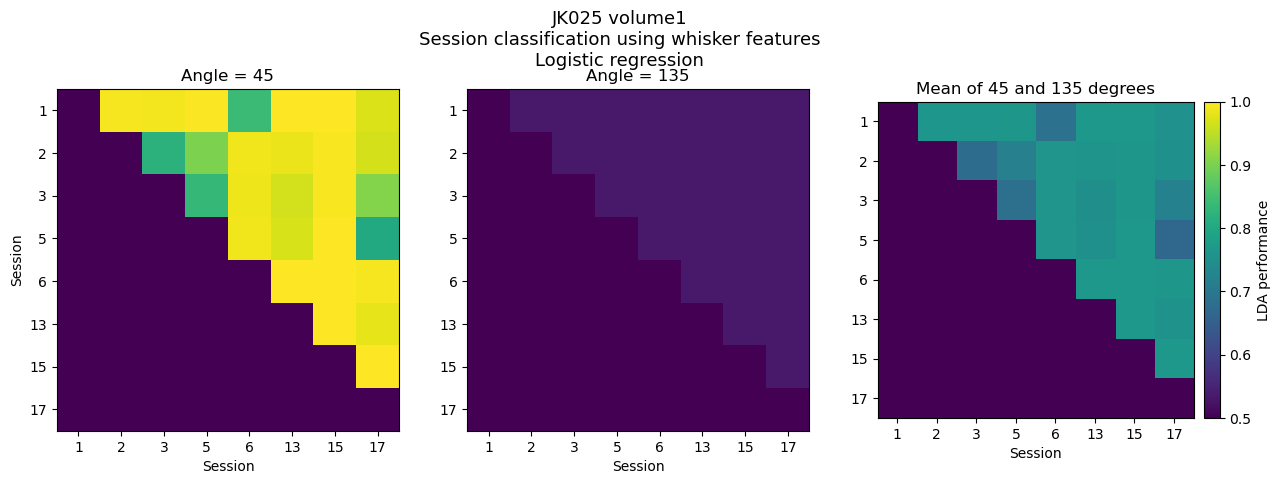

In [135]:
# mouse = 25
# volume = 1
# sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])
# logireg_mat_45, logireg_mat_135 = get_logireg_perf(mouse, volume, sessions, results_dir)
draw_logireg_fig(mouse, volume, sessions, logireg_mat_45, logireg_mat_135)

# Running in multiprocessing
- scripts/session_discrim_using_whisker_features

## Results analysis
- Also compare between L1 and L2 regularization

In [76]:
logireg_dir = results_dir / r'whisker_feature_discrim\session_discrim'
mouse = 52
volume = 1
penalty = 'l2'
fn = logireg_dir / f'JK{mouse:03}_volume{volume}_session_discrim_logireg_results_{penalty}.npy'
result = np.load(fn, allow_pickle=True).item()
result.keys()

dict_keys(['accuracy_45', 'accuracy_135', 'coeff_45', 'coeff_135'])

In [71]:
def draw_coeff_fig(result, whisker_feature_names):
    angles = [45, 135]
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    for ai in range(2):
        angle = angles[ai]
        temp_mat = result[f'coeff_{angle}']
        neighboring_abs_coeff_temp = np.stack([np.abs(temp_mat[i,j,1:]) for (i,j) in zip(range(temp_mat.shape[0]-1), range(1, temp_mat.shape[0]))])

        # ax[ai].imshow(neighboring_abs_coeff_temp, aspect='auto')
        ax[ai].bar(range(len(whisker_feature_names)), neighboring_abs_coeff_temp.mean(axis=0))
        ax[ai].errorbar(range(len(whisker_feature_names)), neighboring_abs_coeff_temp.mean(axis=0),
                        yerr=neighboring_abs_coeff_temp.std(axis=0), fmt='none')
        # ax[ai].set_ylabel('Neighboring pairs')
        ax[ai].set_ylabel('Absolute coefficient')
        ax[ai].set_xticks(range(len(whisker_feature_names)))
        ax[ai].set_xticklabels(whisker_feature_names, rotation=45, ha='right');
        ax[ai].set_title(f'Angle {angle}')
    fig.suptitle(f'JK{mouse:03} volume {volume} penalty {penalty} Abs coefficients\n\
                 Neighboring pair of sessions')
    return fig, ax


In [100]:
def draw_coeff_fig_concat(mouse):
    fig = plt.figure(figsize=(24,12))
    outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.5)
    angles = [45, 135]
    for vi, volume in enumerate(range(1,3)):
        for pi, penalty in enumerate(['l1', 'l2']):
            fn = logireg_dir / f'JK{mouse:03}_volume{volume}_session_discrim_logireg_results_{penalty}.npy'
            result = np.load(fn, allow_pickle=True).item()
            inner = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=outer[vi, pi])
            ax = plt.Subplot(fig, outer[vi, pi])
            ax.set_title(f'Volume {volume} - Penalty {penalty}', y=1.05, fontsize=15)
            ax.axis('off')
            fig.add_subplot(ax)
            for ai in range(2):
                angle = angles[ai]
                ax = plt.Subplot(fig, inner[ai])
                temp_mat = result[f'coeff_{angle}']
                neighboring_abs_coeff_temp = np.stack([np.abs(temp_mat[i,j,1:]) for (i,j) in zip(range(temp_mat.shape[0]-1), range(1, temp_mat.shape[0]))])

                ax.bar(range(len(whisker_feature_names)), neighboring_abs_coeff_temp.mean(axis=0))
                ax.errorbar(range(len(whisker_feature_names)), neighboring_abs_coeff_temp.mean(axis=0),
                                yerr=neighboring_abs_coeff_temp.std(axis=0), fmt='none')
                ax.set_ylabel('Absolute coefficient')
                ax.set_xticks(range(len(whisker_feature_names)))
                ax.set_xticklabels(whisker_feature_names, rotation=45, ha='right');
                ax.set_title(f'Angle {angle}')
                fig.add_subplot(ax)
    fig.suptitle(f'JK{mouse:03} - Between beighboring pair of sessions', fontsize=20)
    

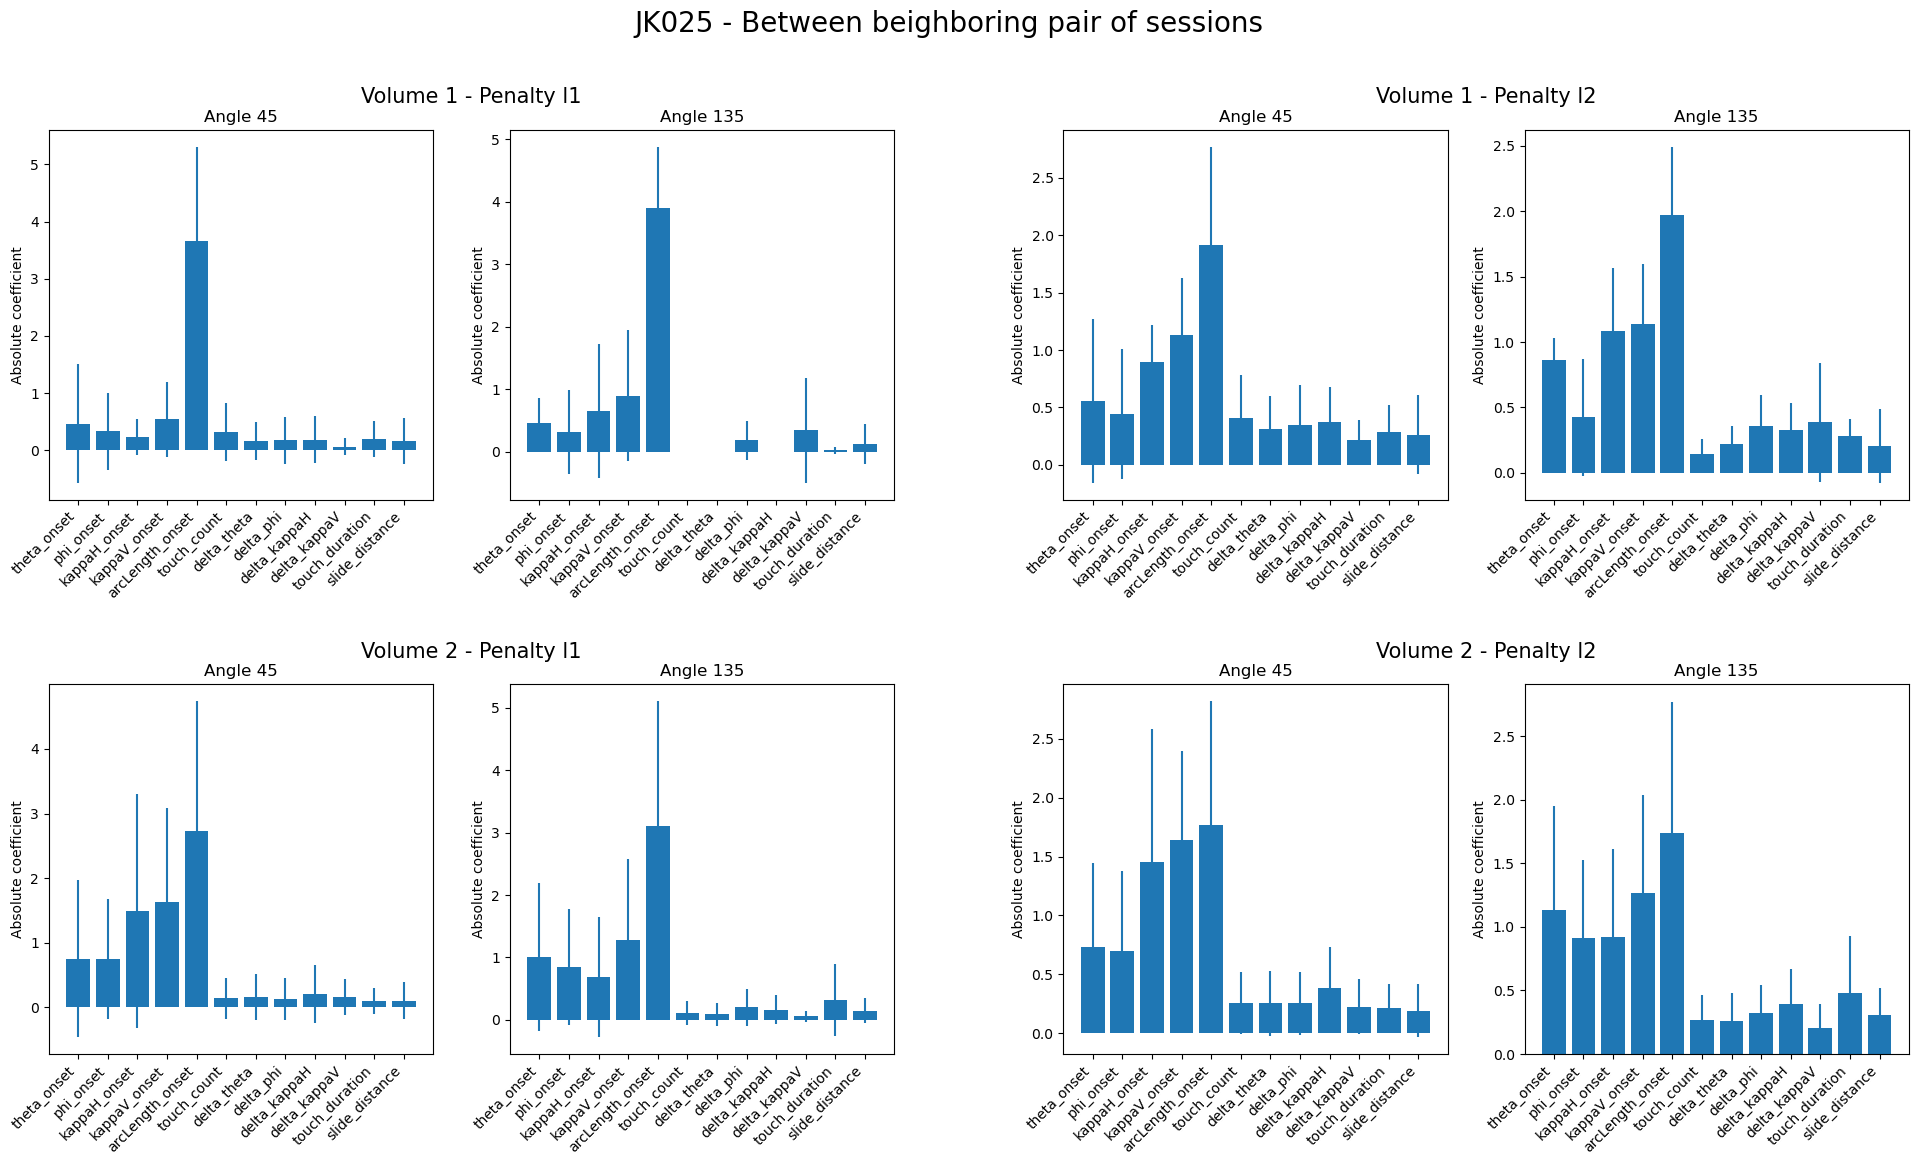

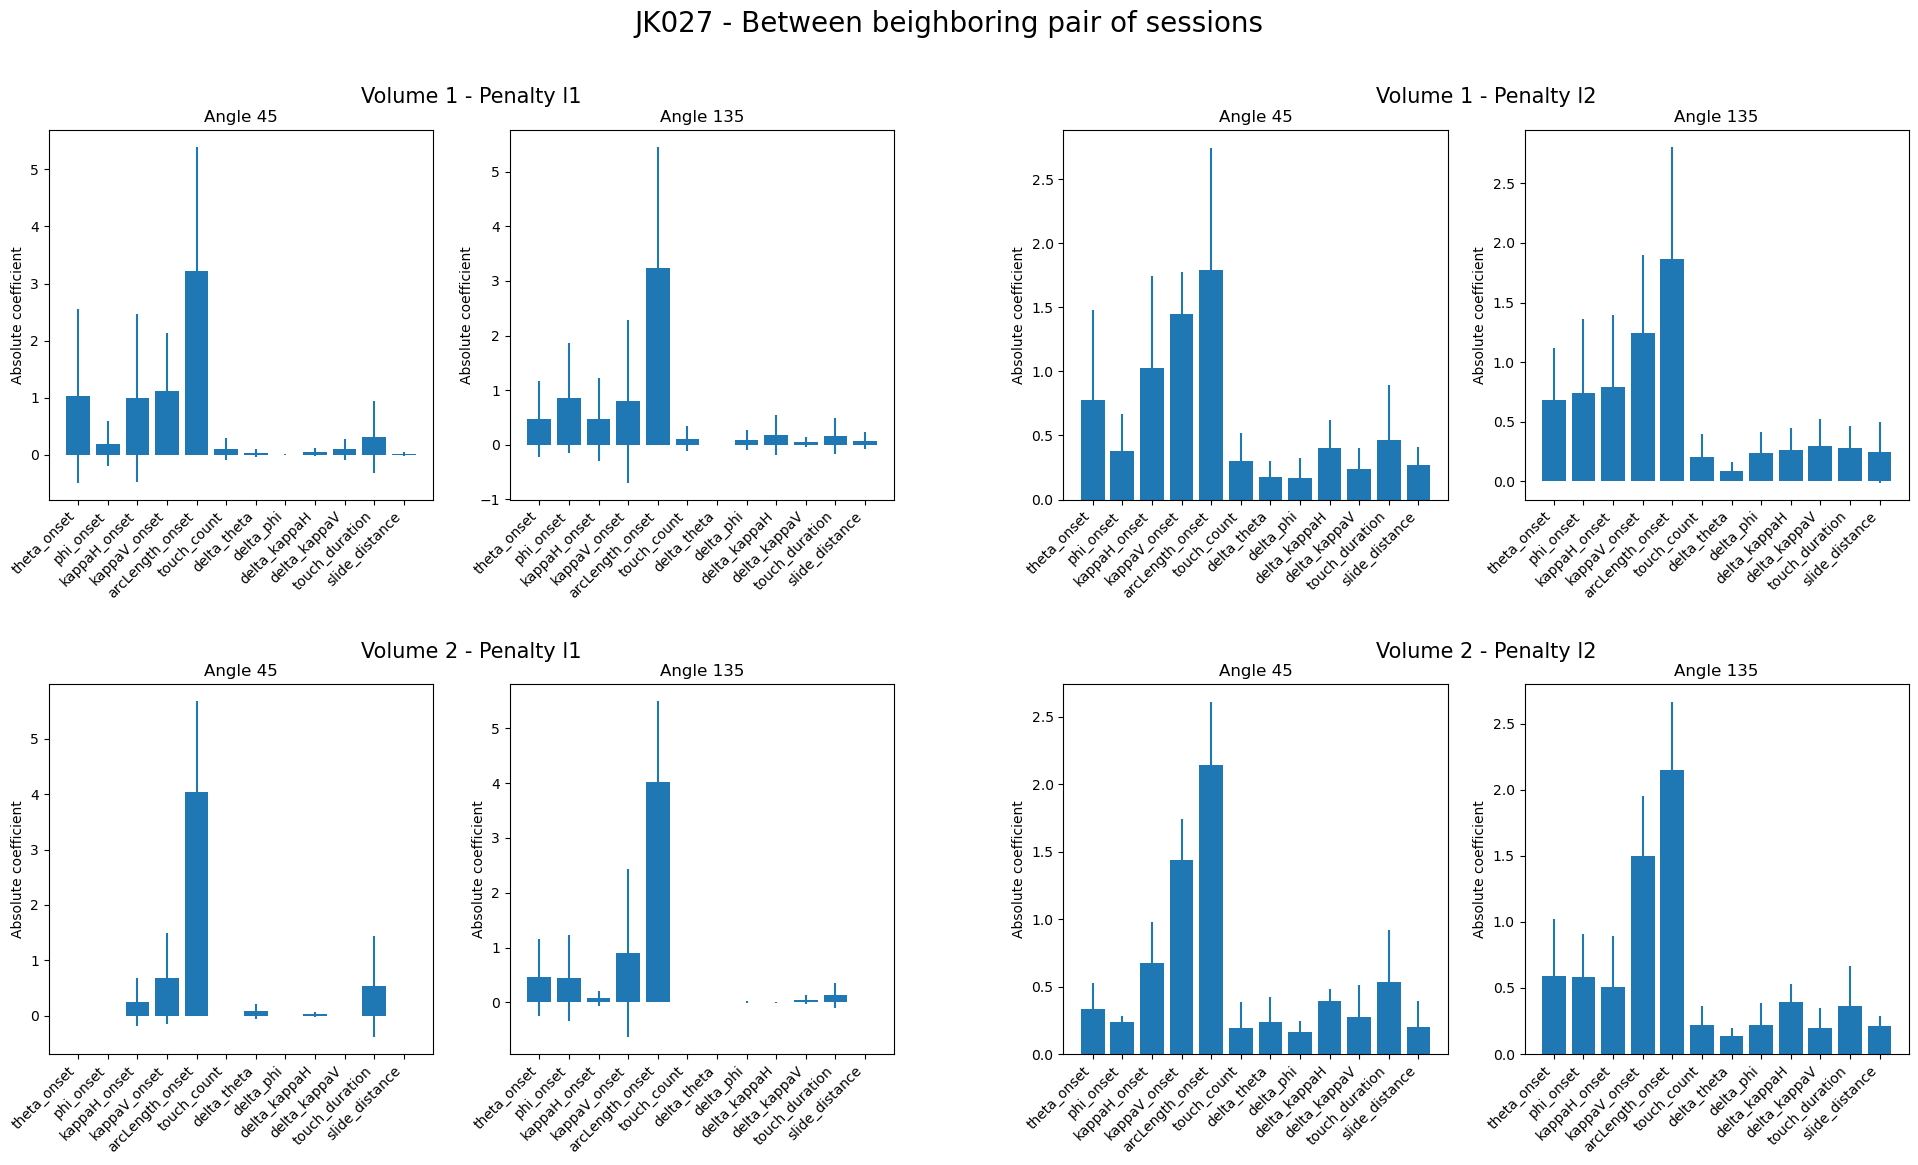

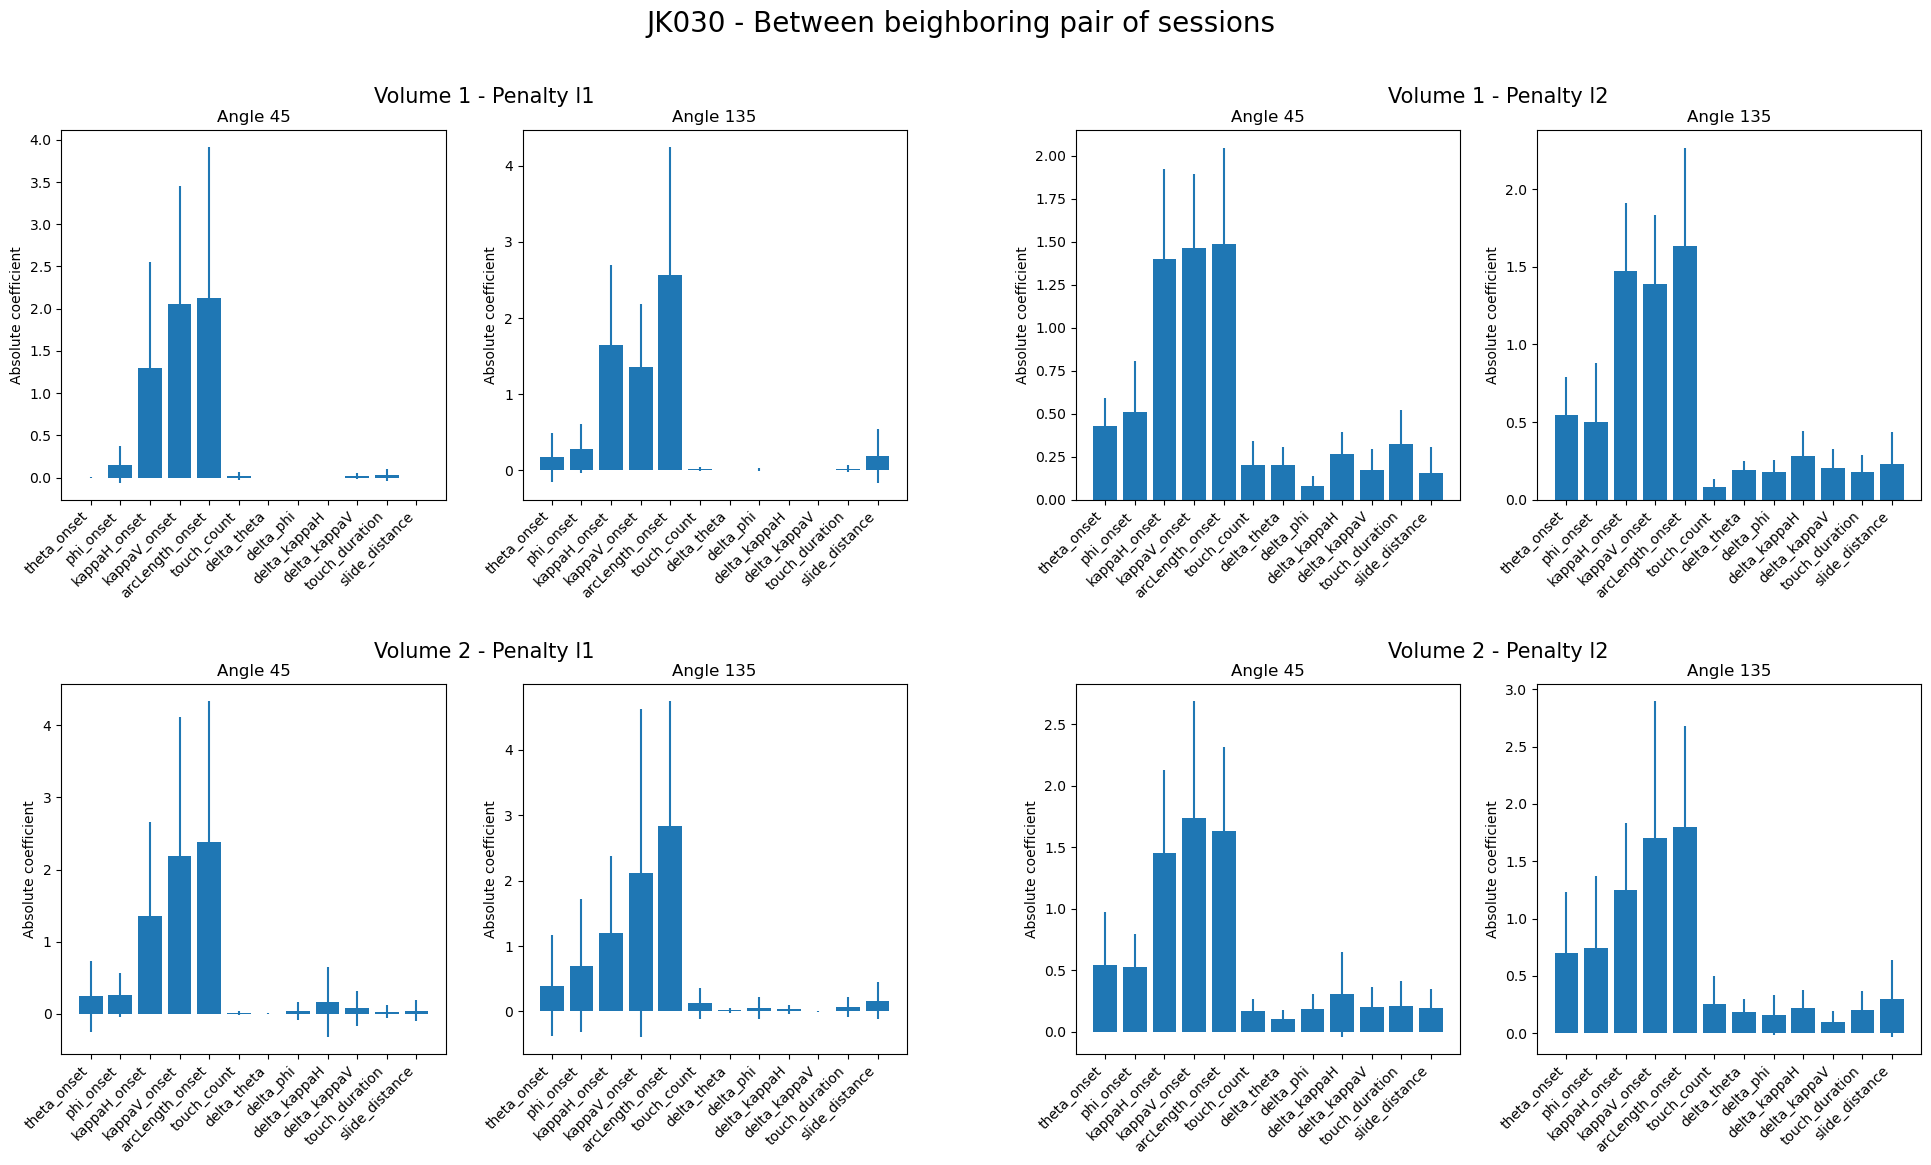

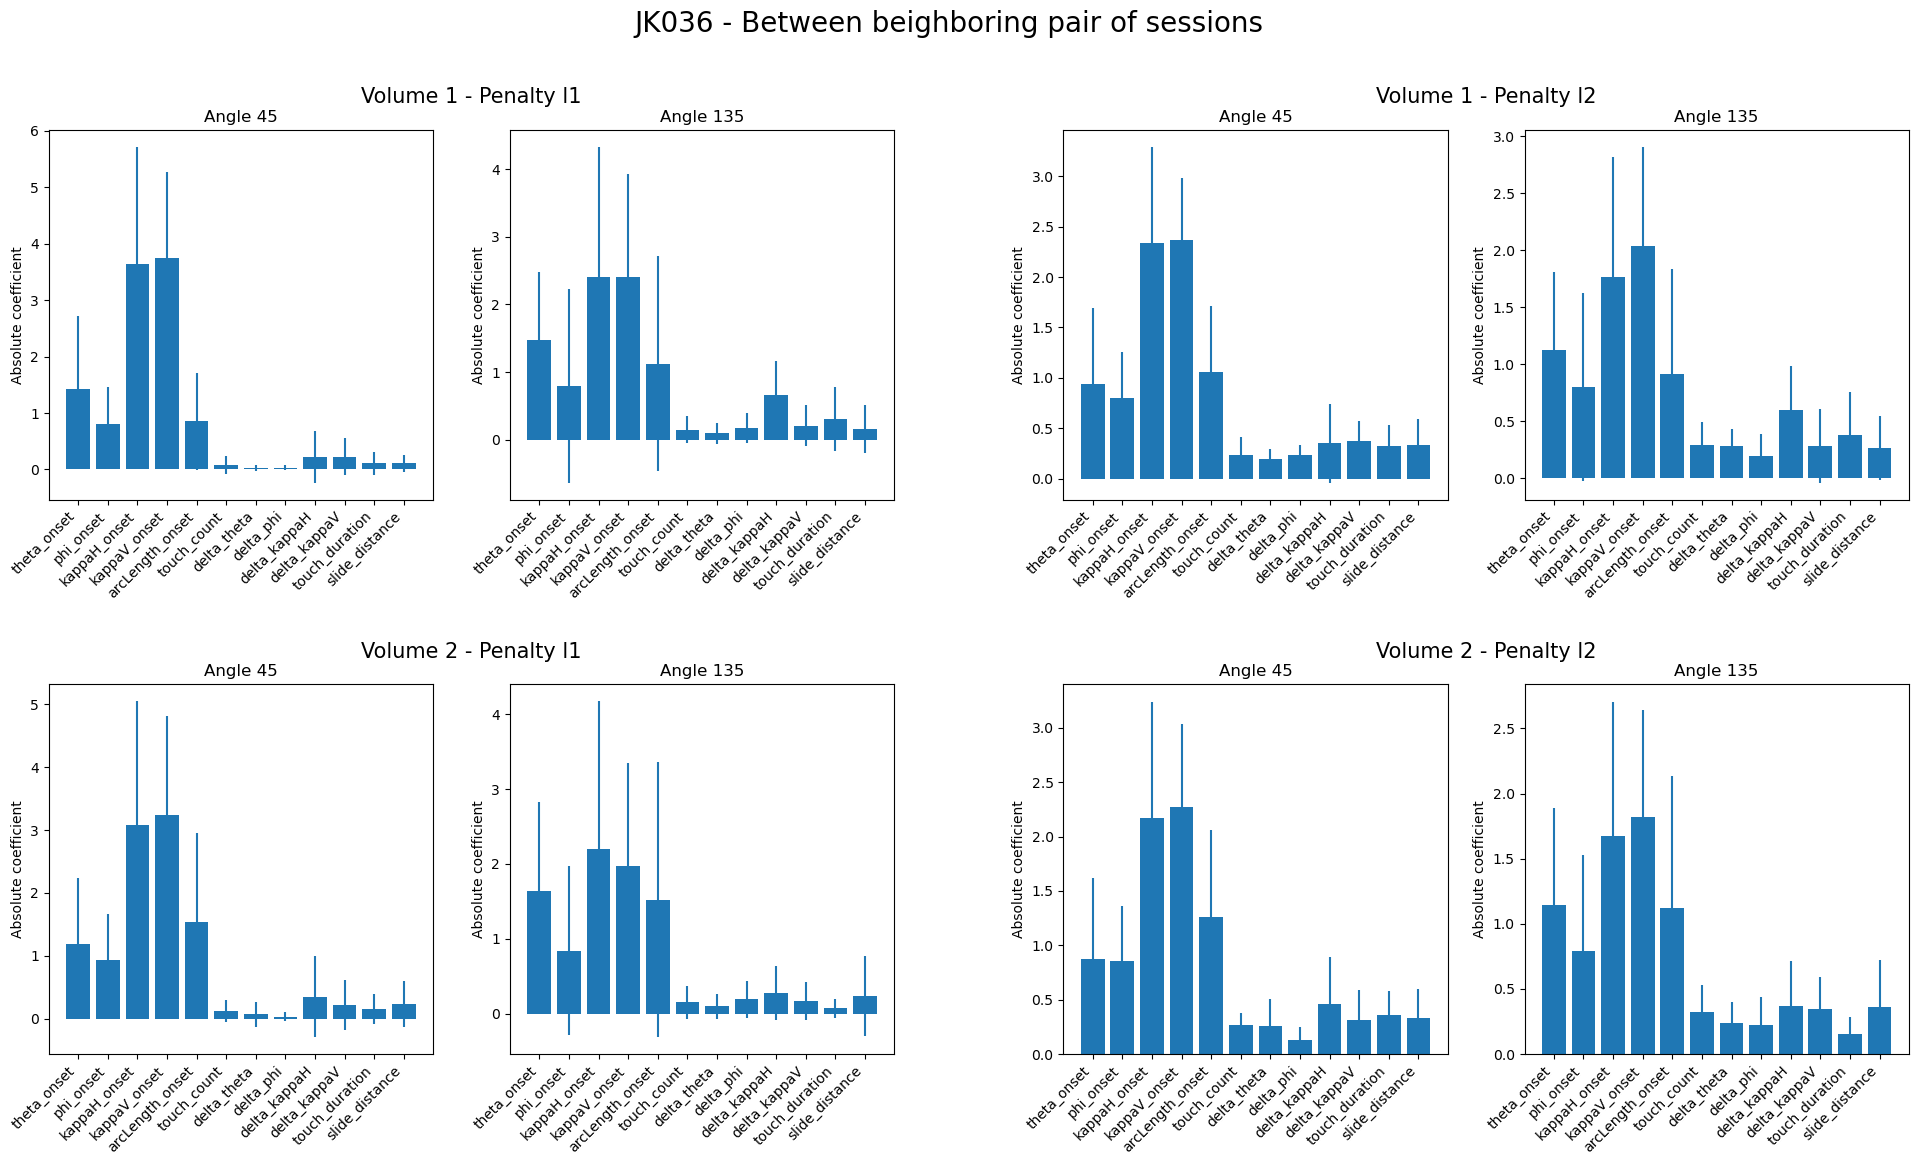

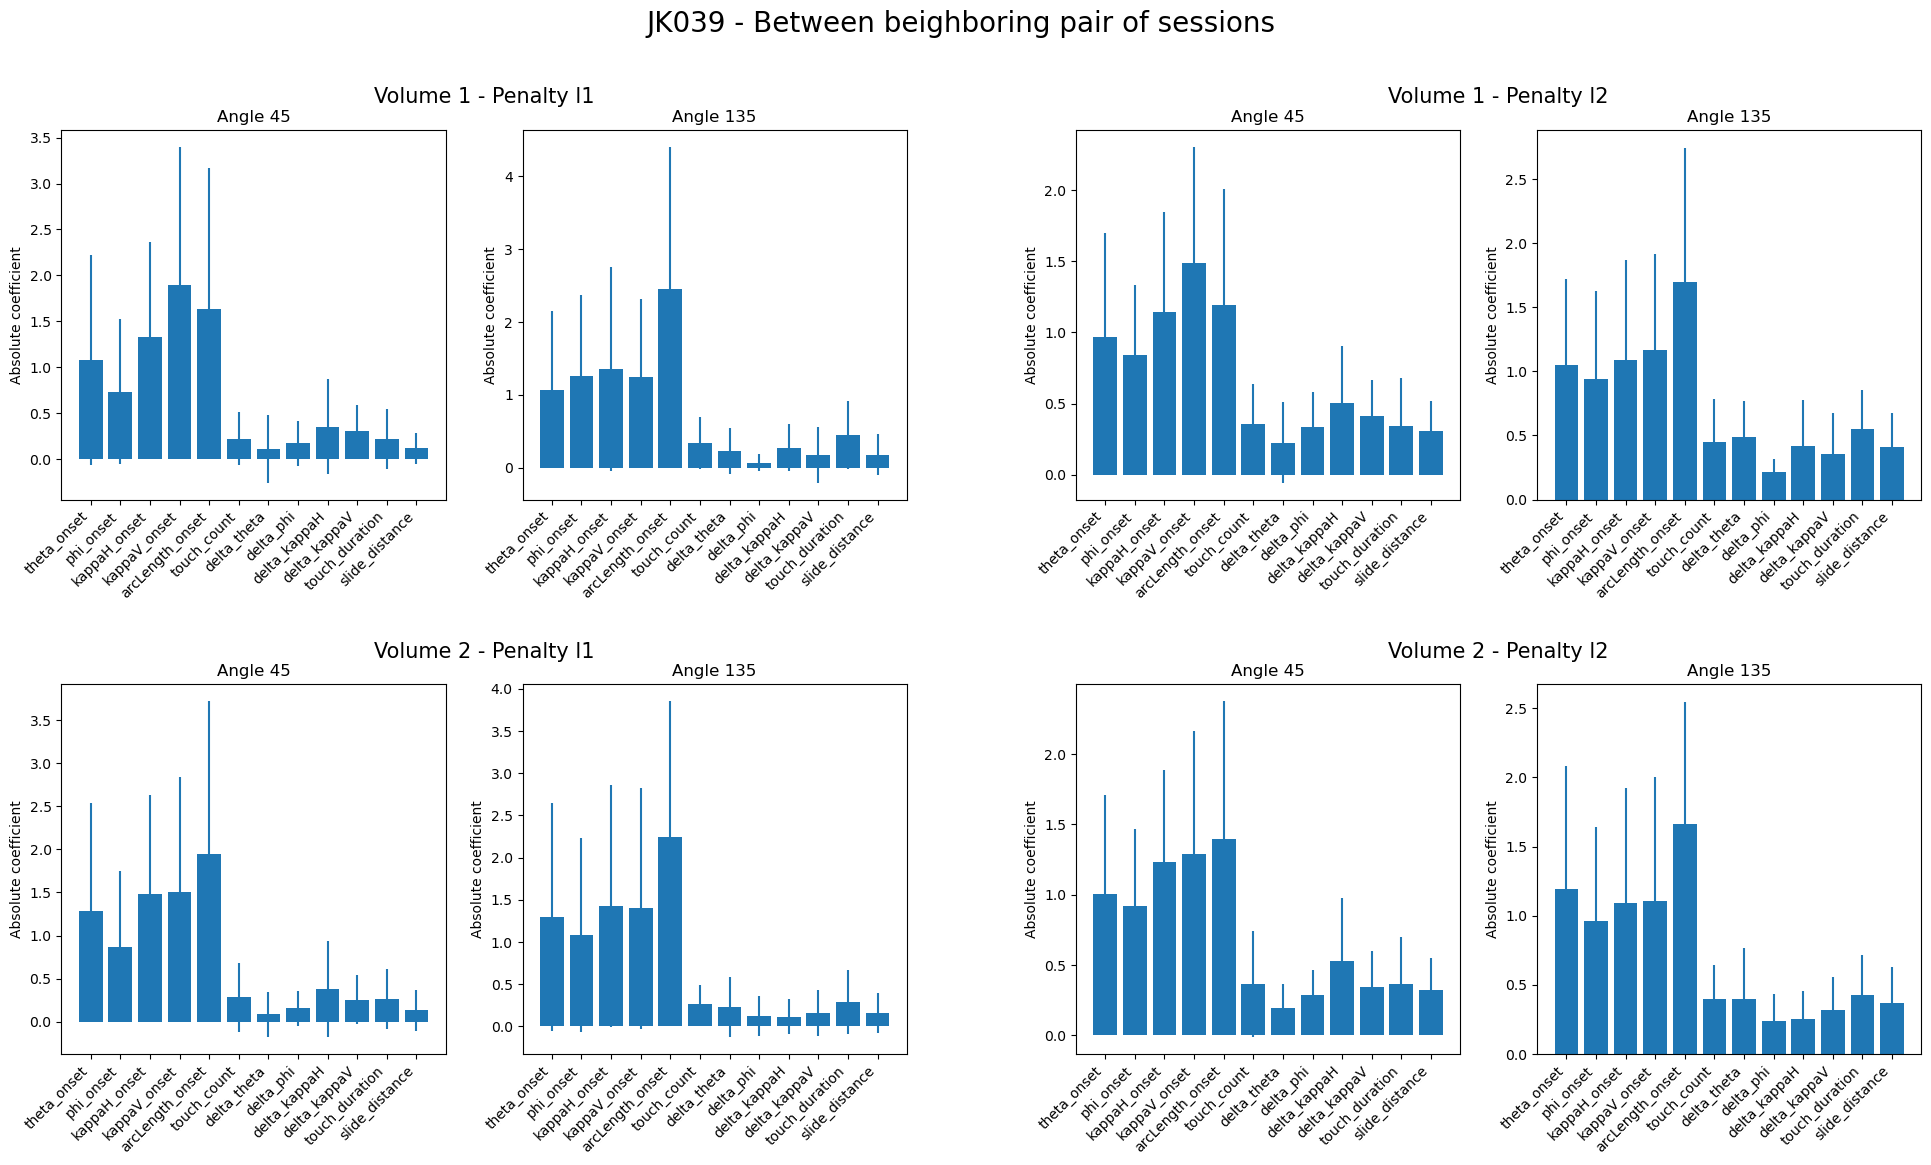

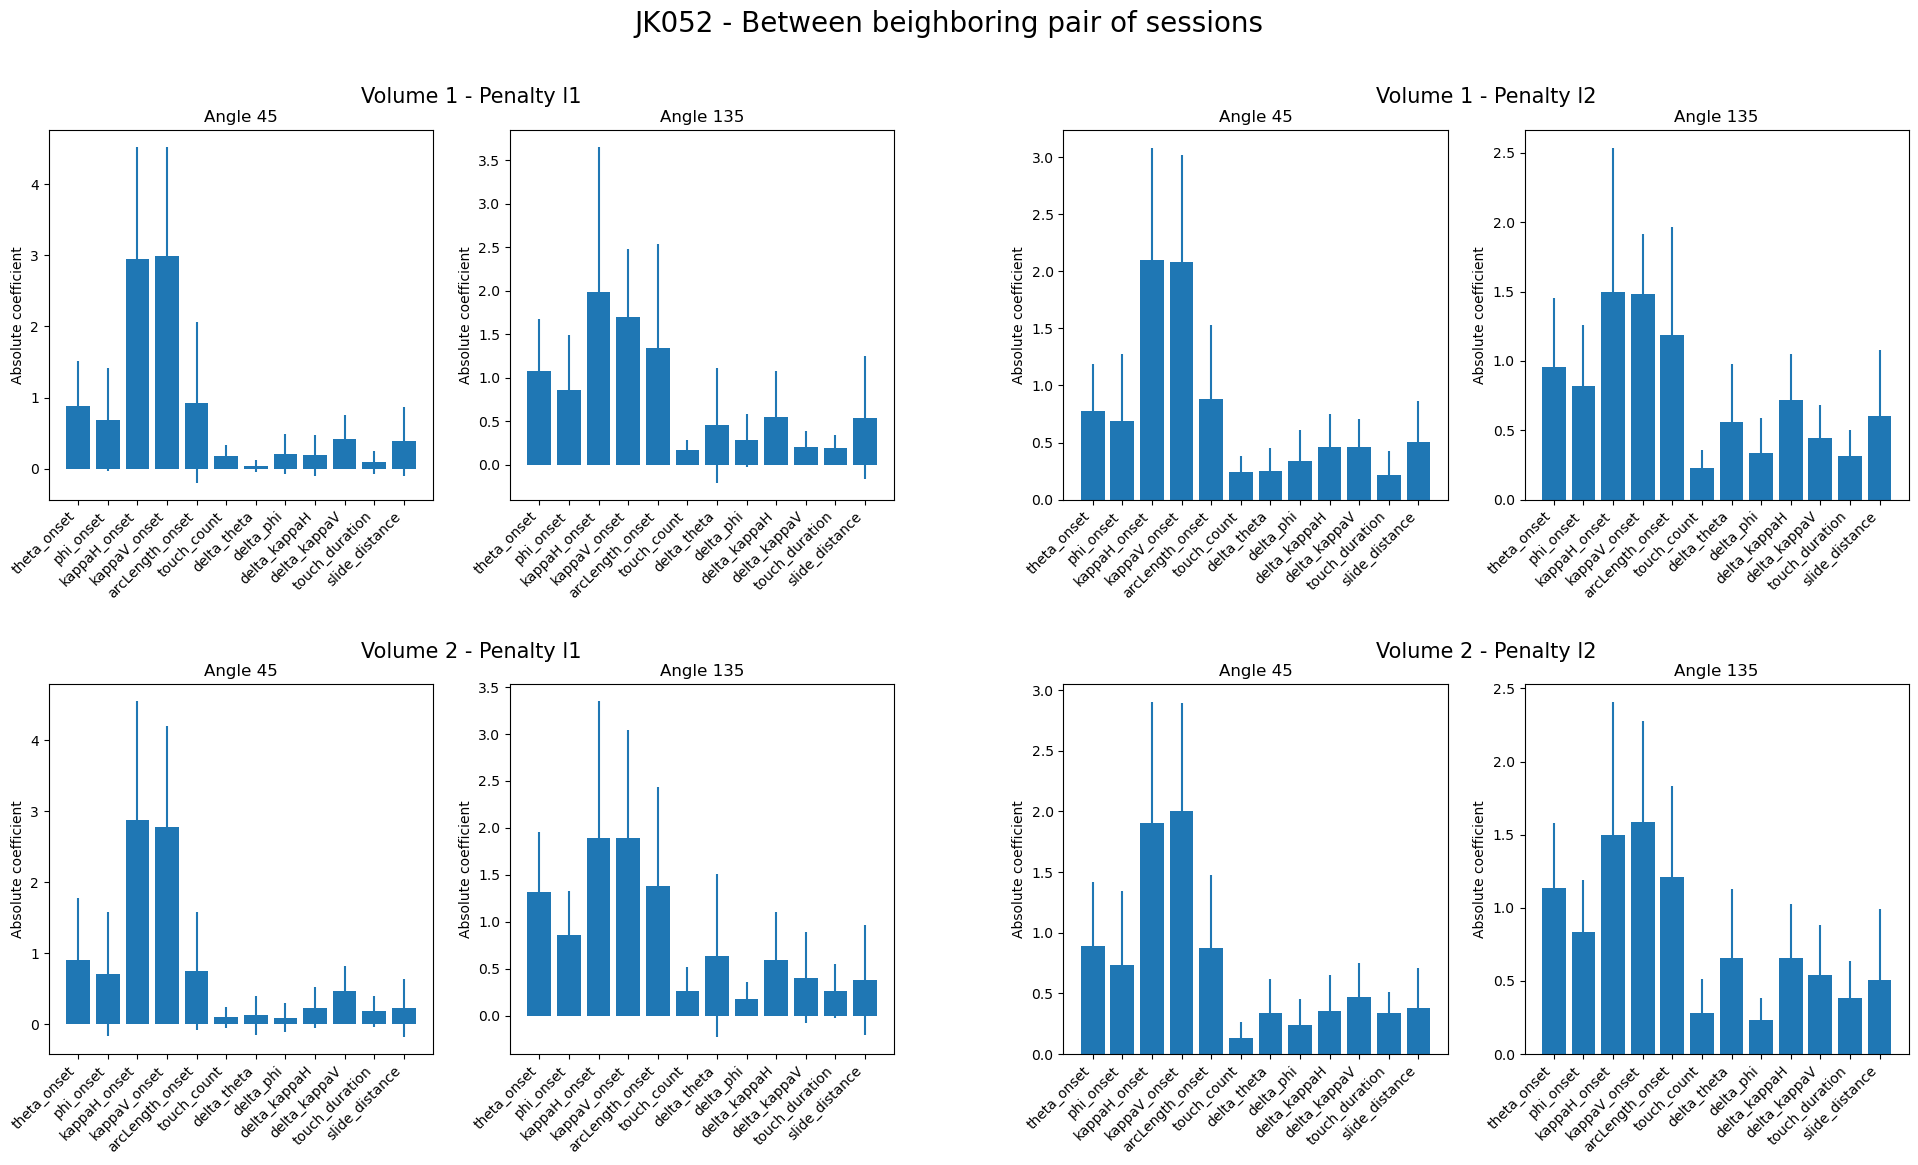

In [102]:
for mouse in mice:
    draw_coeff_fig_concat(mouse)
            

### L1 and L2 performance comparison

In [78]:
logireg_dir = results_dir / r'whisker_feature_discrim\session_discrim'
mouse = 52
volume = 1
penalty = 'l2'
fn = logireg_dir / f'JK{mouse:03}_volume{volume}_session_discrim_logireg_results_{penalty}.npy'
result = np.load(fn, allow_pickle=True).item()


In [122]:
acc_45_l1 = []
acc_135_l1 = []
acc_45_l2 = []
acc_135_l2 = []
for mouse in mice:
    for volume in range(1,3):
        penalty = 'l1'
        fn = logireg_dir / f'JK{mouse:03}_volume{volume}_session_discrim_logireg_results_{penalty}.npy'
        result = np.load(fn, allow_pickle=True).item()
        acc_45_l1.append(result['accuracy_45'][np.triu_indices(result['accuracy_45'].shape[0], k=1)].mean())
        acc_135_l1.append(result['accuracy_135'][np.triu_indices(result['accuracy_135'].shape[0], k=1)].mean())

        penalty = 'l2'
        fn = logireg_dir / f'JK{mouse:03}_volume{volume}_session_discrim_logireg_results_{penalty}.npy'
        result = np.load(fn, allow_pickle=True).item()
        acc_45_l2.append(result['accuracy_45'][np.triu_indices(result['accuracy_45'].shape[0], k=1)].mean())
        acc_135_l2.append(result['accuracy_135'][np.triu_indices(result['accuracy_135'].shape[0], k=1)].mean())

Text(0, 0.5, 'Accuracy')

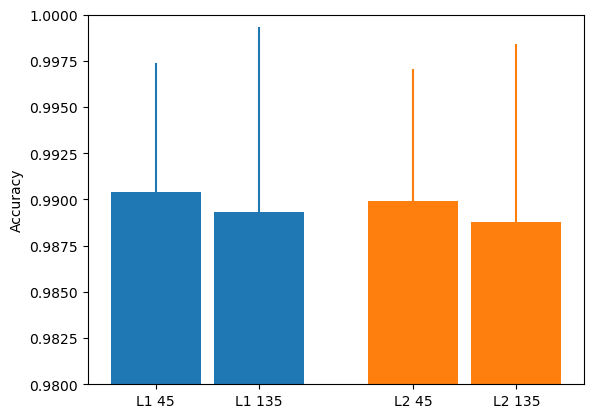

In [132]:
fig, ax = plt.subplots()
ax.bar(0.8, np.mean(acc_45_l1), color='C0', width=0.35)
ax.bar(1.2, np.mean(acc_135_l1), color='C0', width=0.35)
ax.bar(1.8, np.mean(acc_45_l2), color='C1', width=0.35)
ax.bar(2.2, np.mean(acc_135_l2), color='C1', width=0.35)
ax.errorbar(0.8, np.mean(acc_45_l1), yerr=np.std(acc_45_l1), fmt='none', color='C0')
ax.errorbar(1.2, np.mean(acc_135_l1), yerr=np.std(acc_135_l1), fmt='none', color='C0')
ax.errorbar(1.8, np.mean(acc_45_l2), yerr=np.std(acc_45_l2), fmt='none', color='C1')
ax.errorbar(2.2, np.mean(acc_135_l2), yerr=np.std(acc_135_l2), fmt='none', color='C1')
ax.set_ylim(0.98, 1)
ax.set_xticks([0.8, 1.2, 1.8, 2.2])
ax.set_xticklabels(['L1 45', 'L1 135', 'L2 45', 'L2 135']);
ax.set_ylabel('Accuracy')

### Grand average

In [79]:
logireg_dir = results_dir / r'whisker_feature_discrim\session_discrim'
angles = [45, 135]
coeffs_all = np.zeros((len(mice), 2, 2, 2, 12))
for mouse in mice:
    for vi, volume in enumerate(range(1,3)):
        for pi, penalty in enumerate(['l1', 'l2']):
            fn = logireg_dir / f'JK{mouse:03}_volume{volume}_session_discrim_logireg_results_{penalty}.npy'
            result = np.load(fn, allow_pickle=True).item()
            for ai in range(2):
                angle = angles[ai]
                temp_mat = result[f'coeff_{angle}']
                neighboring_abs_coeff_temp = np.stack([np.abs(temp_mat[i,j,1:]) for (i,j) in zip(range(temp_mat.shape[0]-1), range(1, temp_mat.shape[0]))])
                abs_coeff_temp = np.stack([np.stack([np.abs(temp_mat[i,j,1:]) for i in range(temp_mat.shape[0]-1)])
                                          for j in range(1, temp_mat.shape[0])])
                coeffs_all[mice.index(mouse), vi, pi, ai, :] = np.mean(abs_coeff_temp, axis=(0,1))

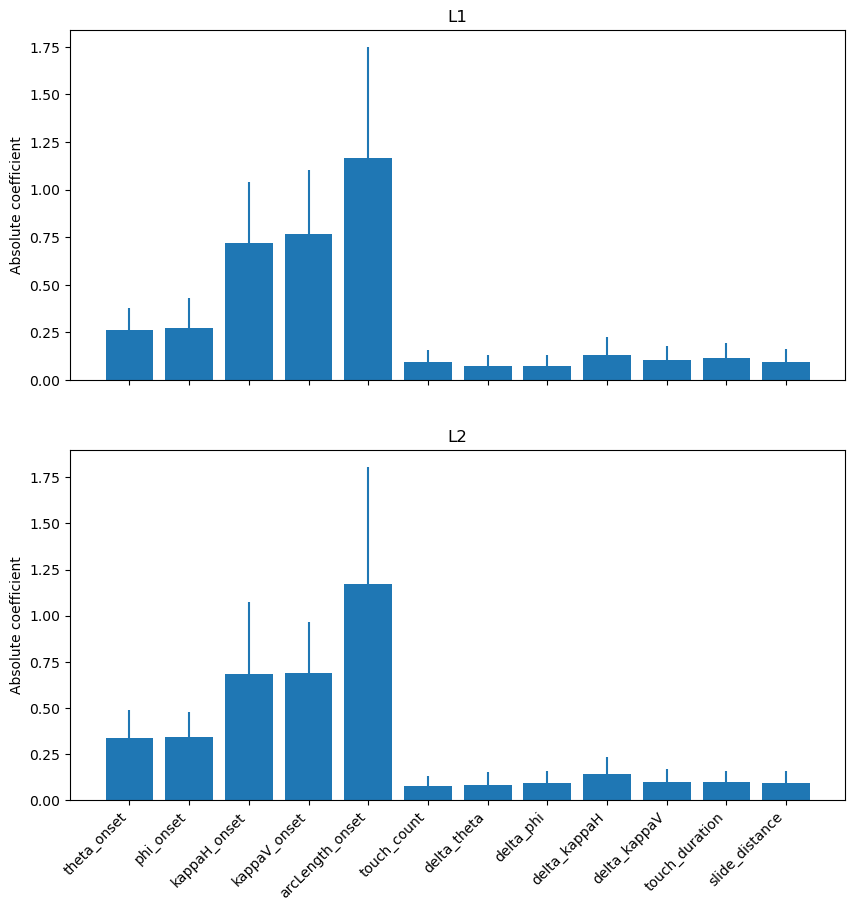

In [7]:
whisker_feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
    'arcLength_onset', 'touch_count', 'delta_theta', 'delta_phi',
    'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
grand_mean = np.mean(coeffs_all, axis=(0,1,2))
grand_std = np.std(coeffs_all, axis=(0,1,2))
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)
title_texts = ['L1', 'L2']
for i in range(2):
    ax[i].bar(range(12), grand_mean[i,:])
    ax[i].errorbar(range(12), grand_mean[i,:],
                yerr=grand_std[i,:], fmt='none')
    ax[i].set_title(title_texts[i])
    ax[i].set_ylabel('Absolute coefficient')
ax[1].set_xticks(range(12))
ax[1].set_xticklabels(whisker_feature_names, rotation=45, ha='right');


# Almost all the sessions can be perfectly distinguished
- How come?
- Look at some pairs, their individual whisker feature distribution
- Also look at logistic regression coefficients
    - which features impact session-to-session discrimination?

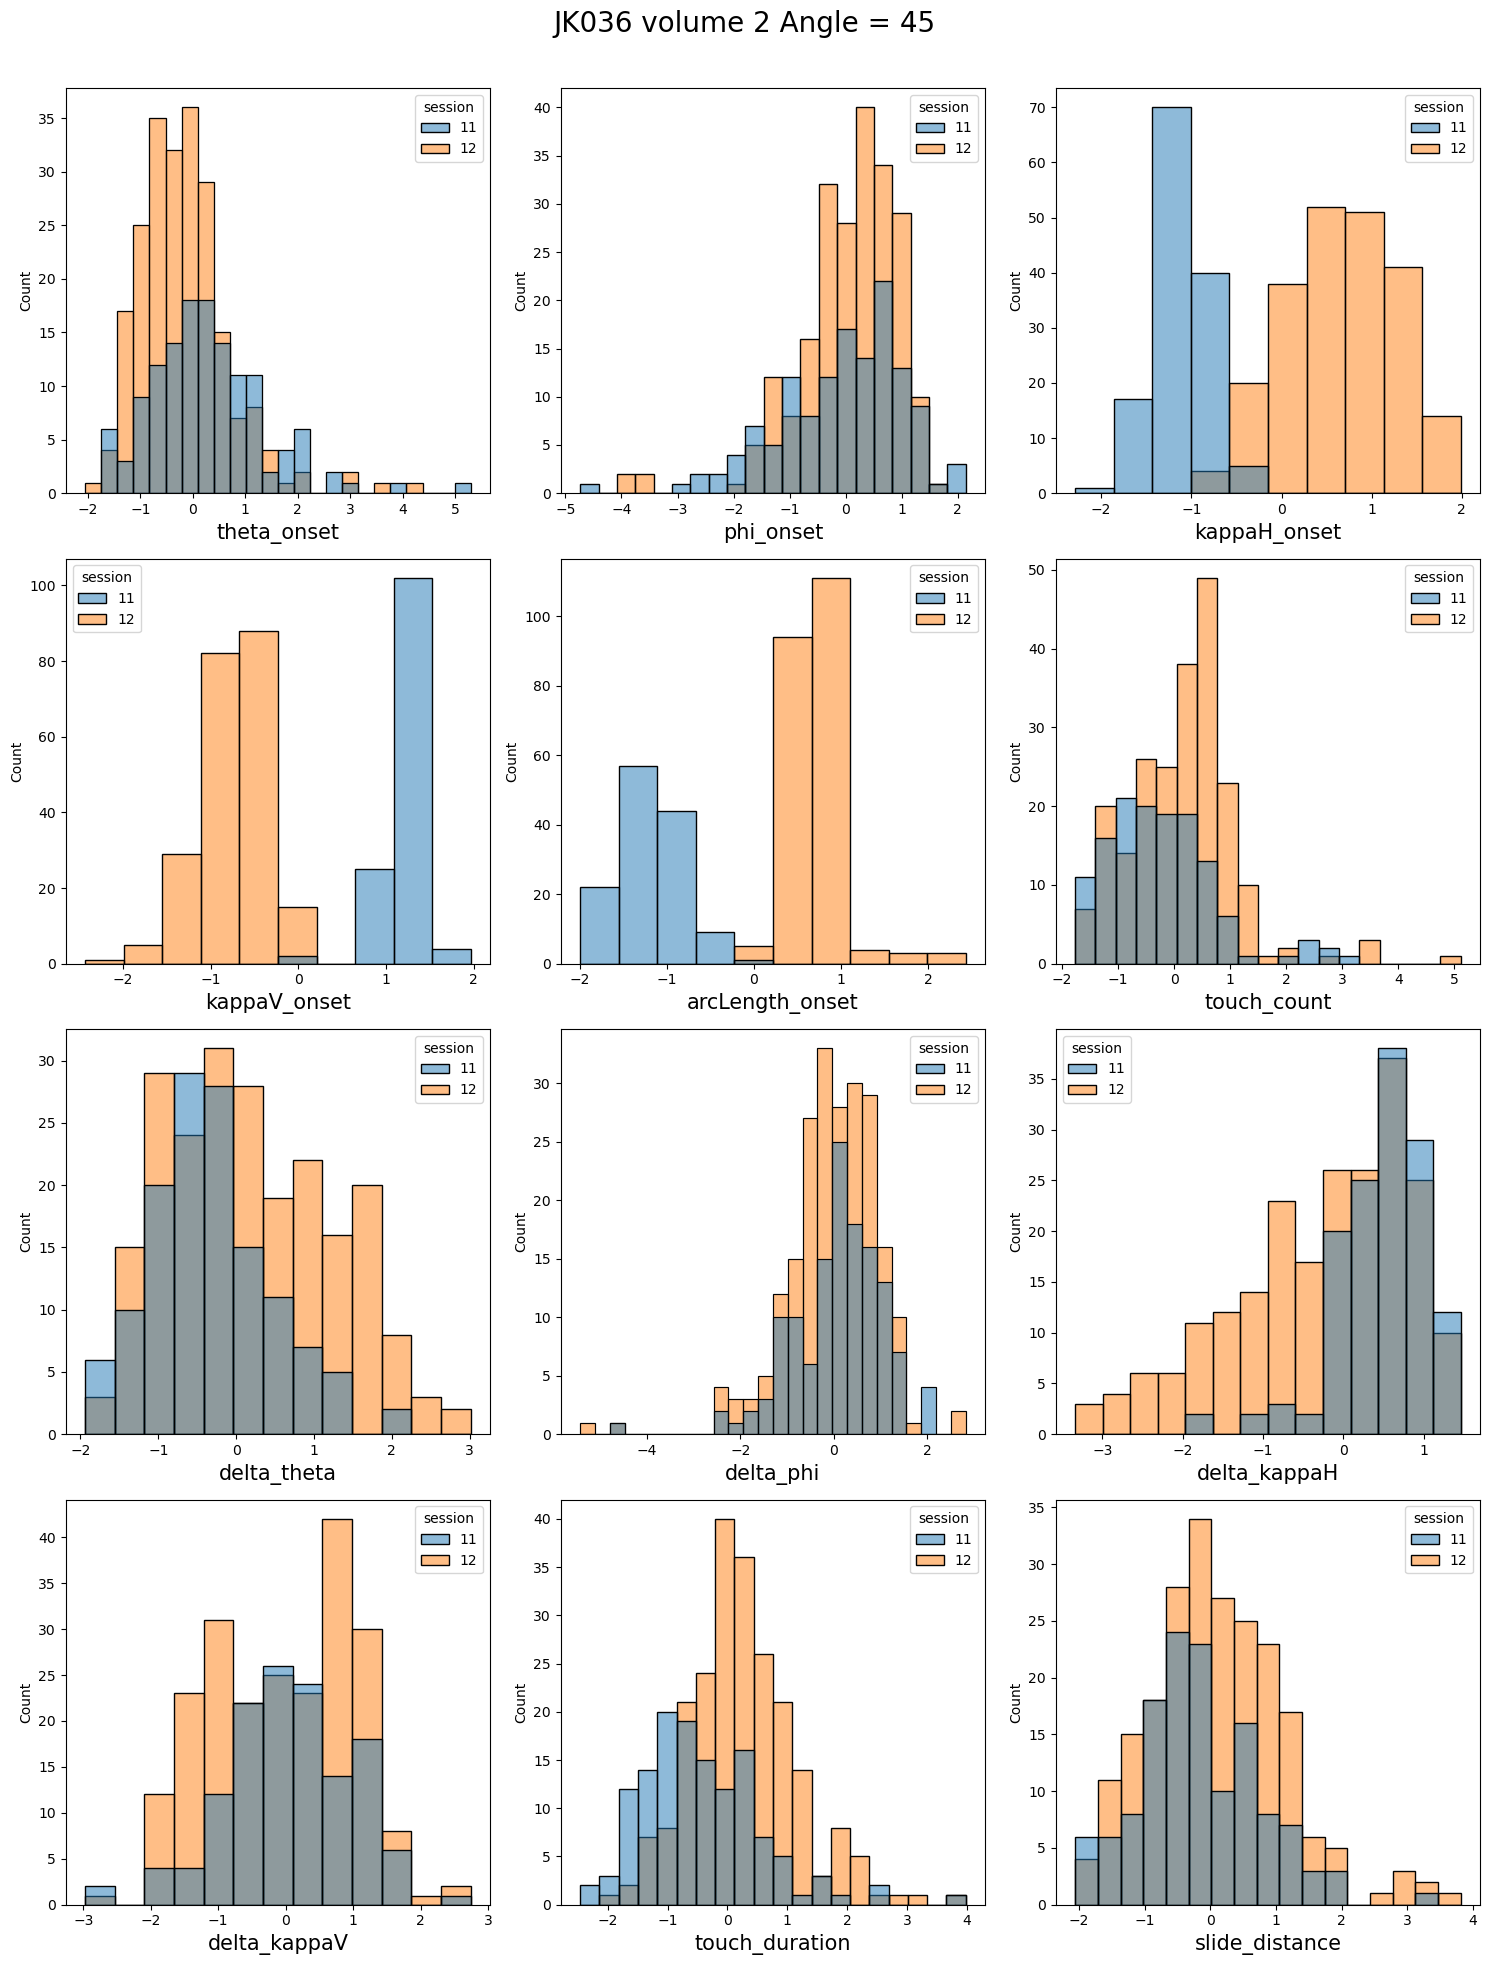

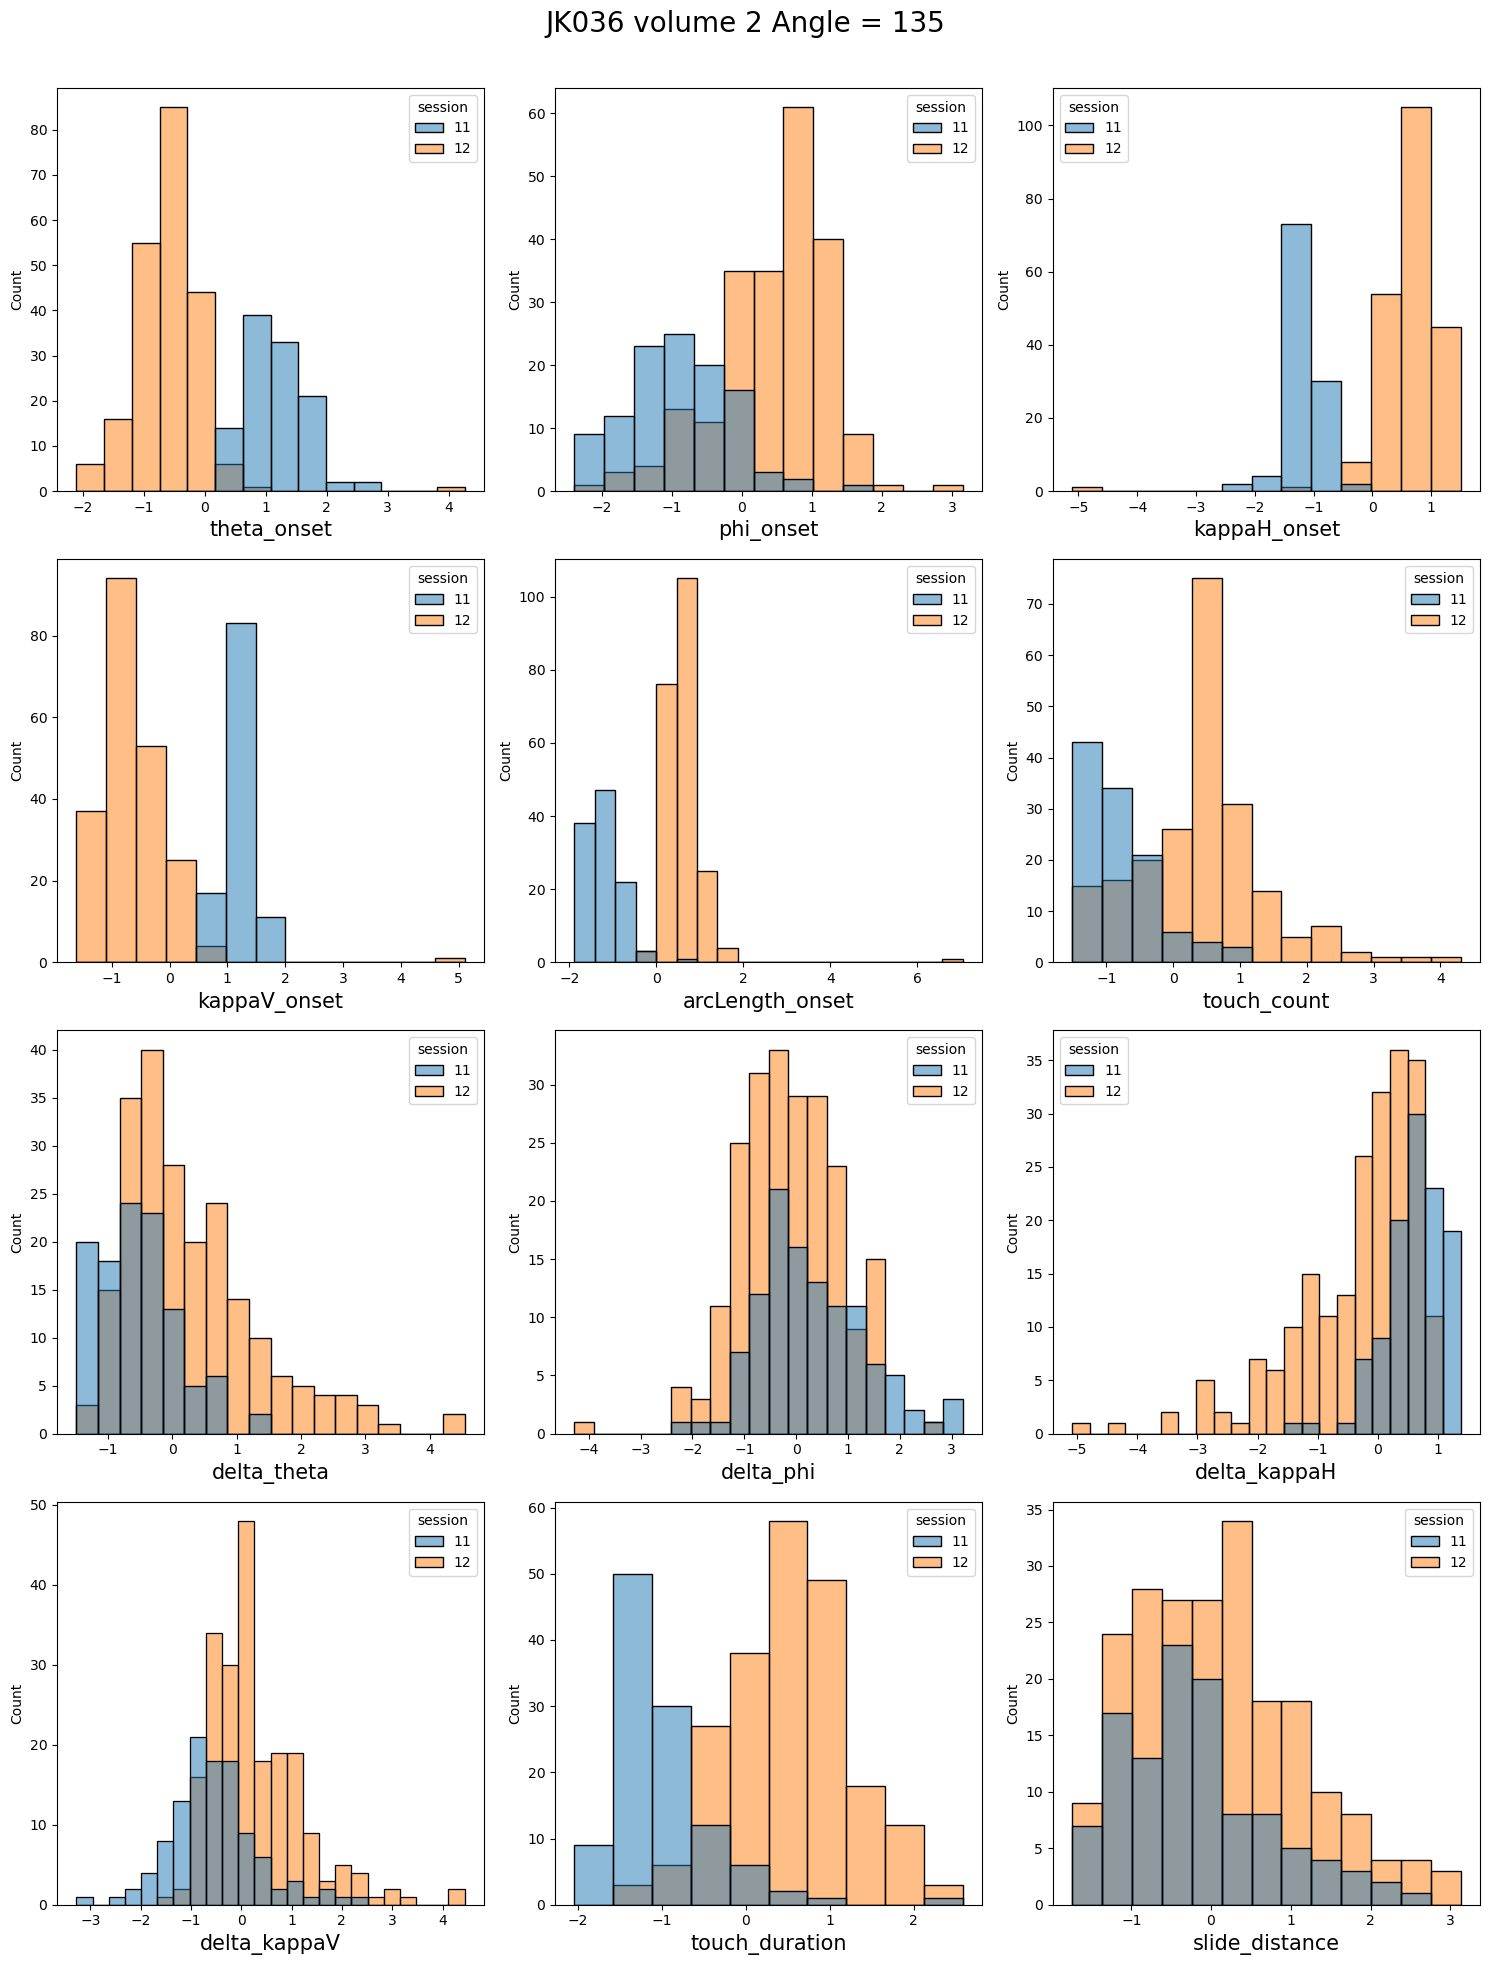

In [90]:
mouse = 36
volume = 2
comp_sessions = [11,12]

comp_df = wf_mean_all.query('session in @comp_sessions')

whisker_feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
        'arcLength_onset', 'touch_count', 'delta_theta', 'delta_phi',
        'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']

angles = [45, 135]
for angle in angles:
    temp_df = comp_df.query('pole_angle == @angle')

    std_df = temp_df.copy()
    for feature in whisker_feature_names:
        std_df[feature] = (temp_df[feature] - temp_df[feature].mean()) / temp_df[feature].std()

    fig, ax = plt.subplots(4,3, figsize=(15,20))
    for i in range(len(whisker_feature_names)):
        axi = ax[i//3, i%3]
        sns.histplot(std_df, x=whisker_feature_names[i], hue='session', ax=axi, palette=sns.color_palette()[:2])
        axi.set_xlabel(whisker_feature_names[i], fontsize=15)
    fig.suptitle(f'JK{mouse:03} volume {volume} Angle = {angle}', fontsize=20)
    fig.tight_layout(rect=[0, 0, 1, 0.97])


## Look at individual features that discriminate sessions

In [91]:
mouse = 25
volume = 1
sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])
wf_mean_all = None
for session in sessions:
    wf_mean_temp = get_whisker_feature_df(mouse, volume, session, results_dir)
    if wf_mean_all is None:
        wf_mean_all = wf_mean_temp
    else:
        wf_mean_all = pd.concat([wf_mean_all, wf_mean_temp])

In [100]:
lda_mat = np.zeros((len(whisker_feature_names), len(sessions), len(sessions), 3))
angles = [45, 135]
for i in range(len(sessions)-1):
    for j in range(i+1, len(sessions)):
        session_i = sessions[i]
        session_j = sessions[j]
        comp_df = wf_mean_all.query('session in [@session_i, @session_j]')
        for angle in angles:
            temp_df = comp_df.query('pole_angle == @angle')

            y = temp_df.session.values == session_i
            for wfi in range(len(whisker_feature_names)):
                whisker_feature = whisker_feature_names[wfi]
                X = temp_df[whisker_feature].values

                lda_acc = lda_angle.get_lda_accuracies(X, y)

                if angle == 45:
                    lda_mat[wfi, i, j, 0] = lda_acc
                else:
                    lda_mat[wfi, i, j, 1] = lda_acc
lda_mat[:,:,:,2] = np.mean(lda_mat[:,:,:,:2], axis=3)

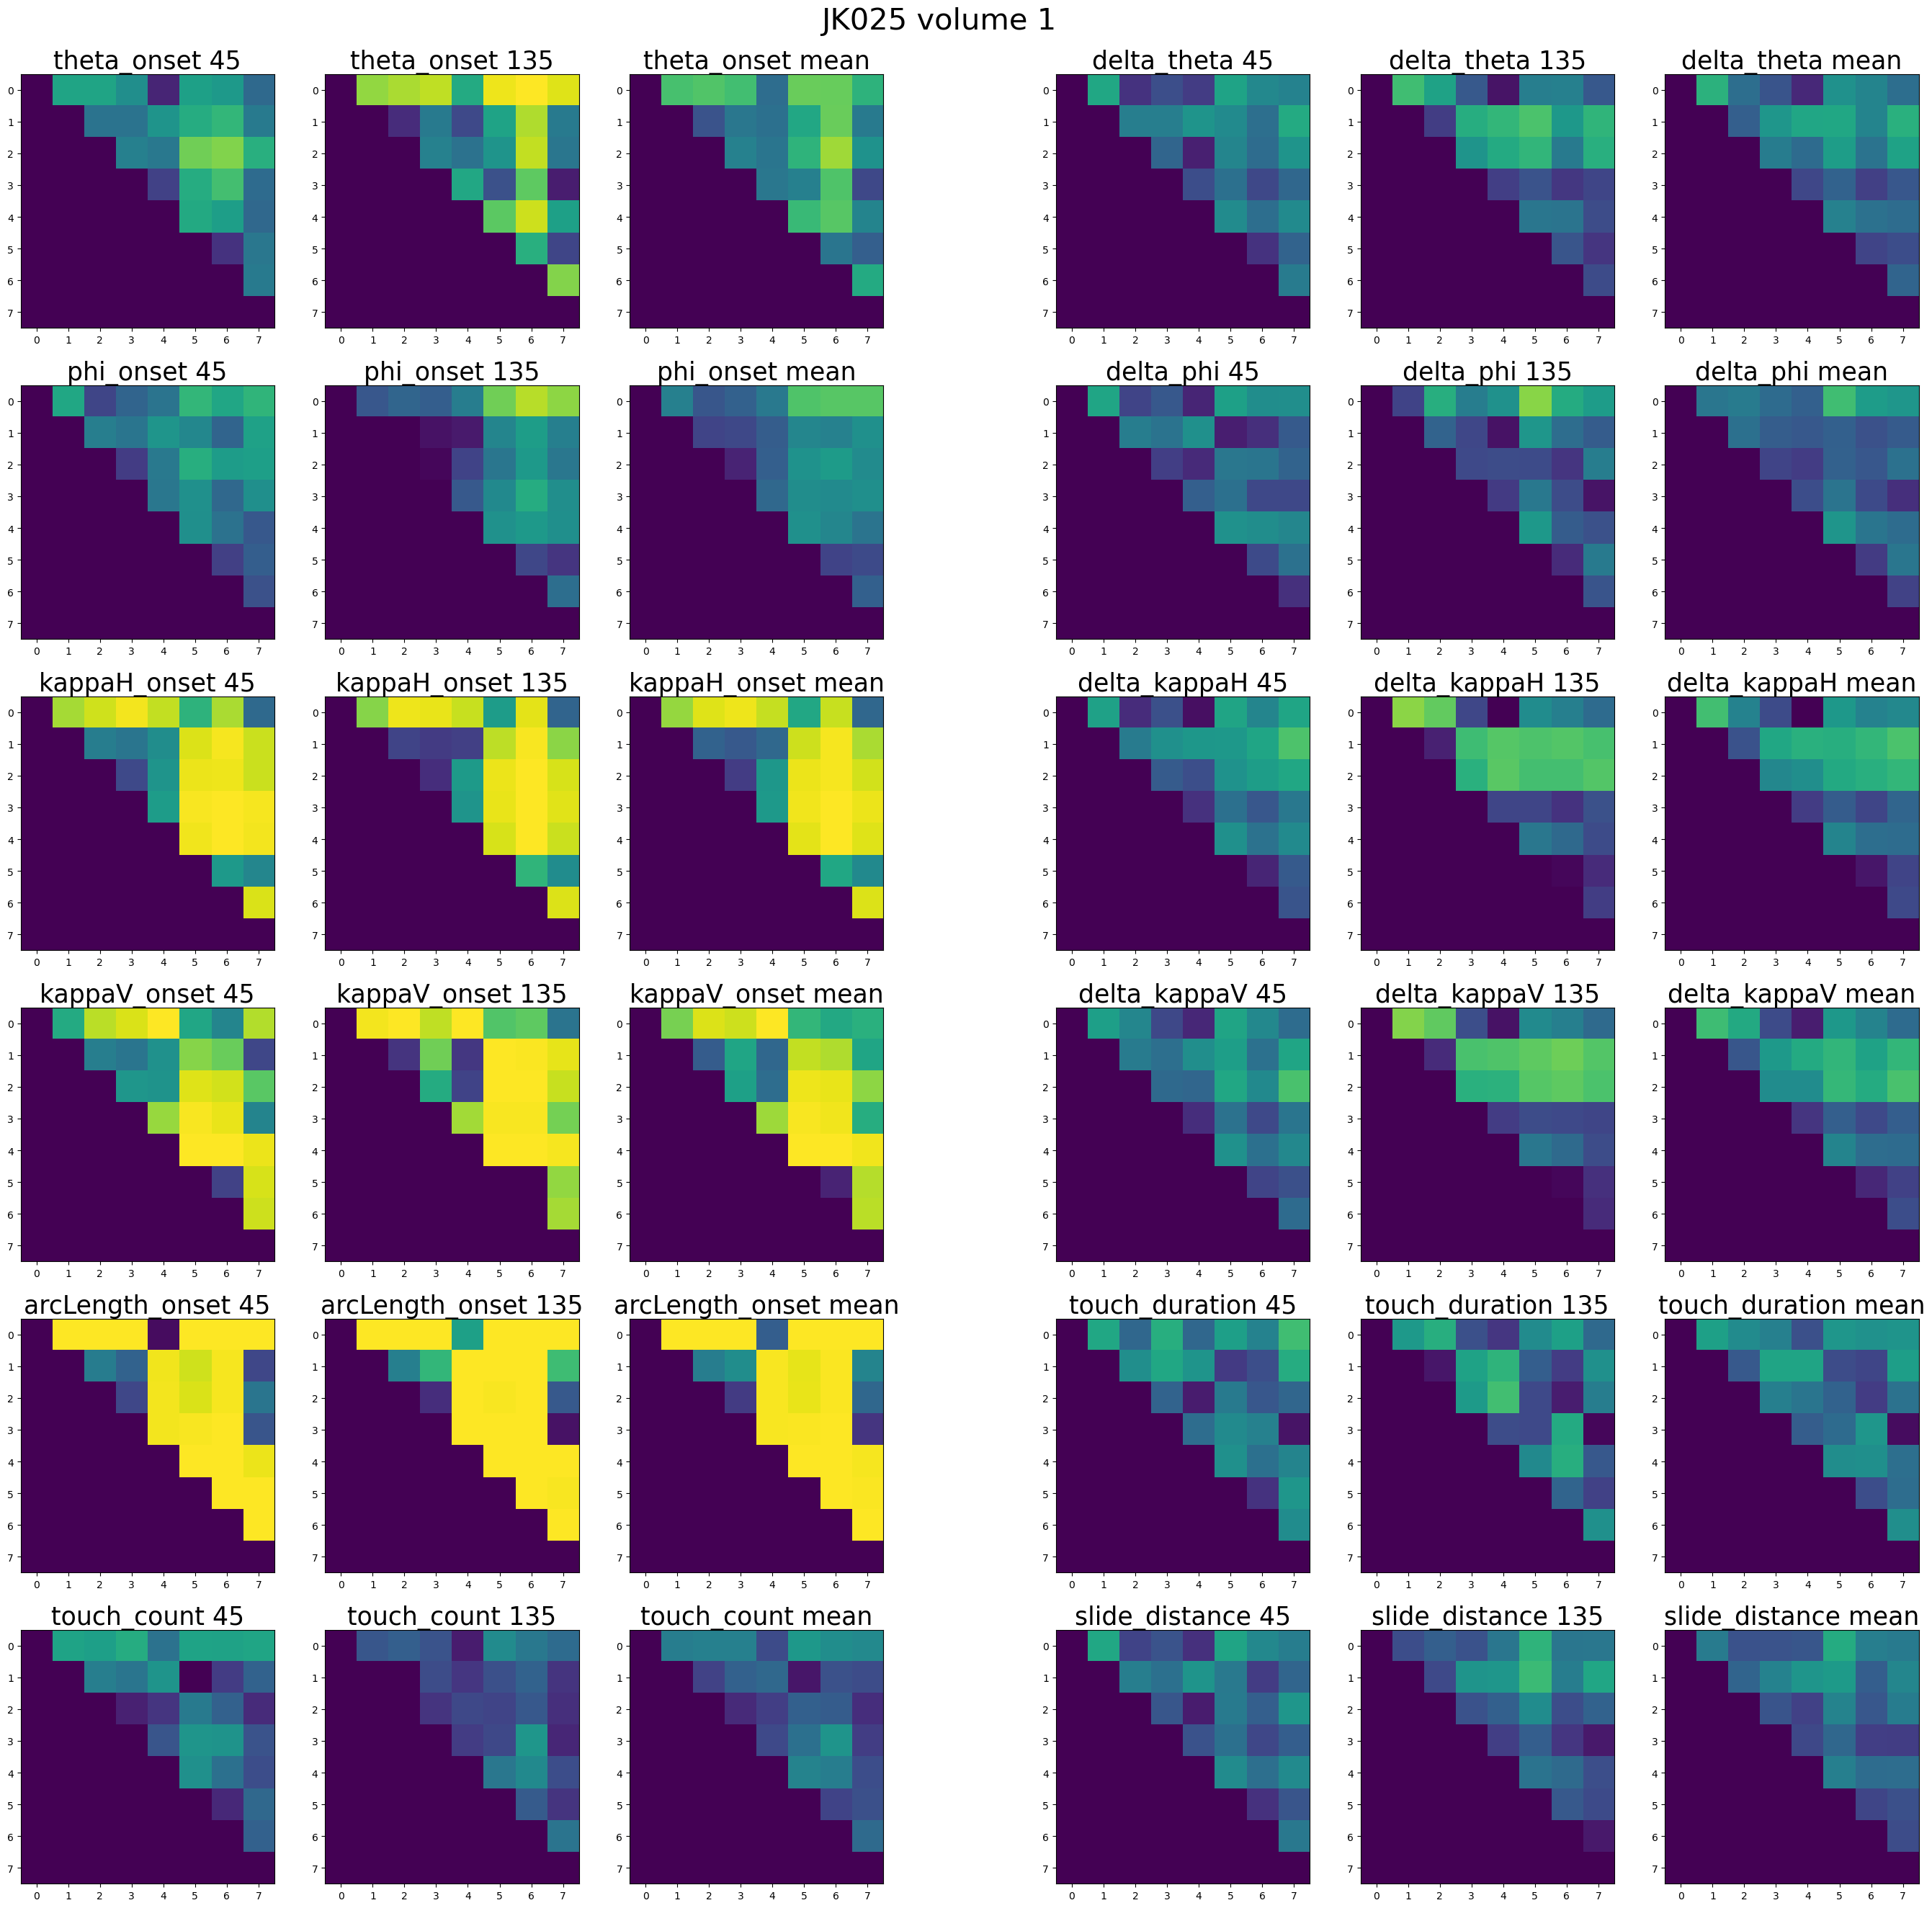

In [123]:
vmin = 0.5
vmax = 1
fig = plt.figure(figsize=(34, 30))
outer = gridspec.GridSpec(1,2, wspace=0.2)
for spi in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(6,3, subplot_spec=outer[spi])
    for j in range(6):
        for k in range(3):
            ax = plt.Subplot(fig, inner[j,k])
            ax.imshow(lda_mat[spi*6+j,:,:,k], vmin=vmin, vmax=vmax)
            ax.set_title(f'{whisker_feature_names[spi*6+j]} {title_texts[k]}', fontsize=25)
            fig.add_subplot(ax)

fig.suptitle(f'JK{mouse:03} volume {volume}', fontsize=30)
fig.subplots_adjust(top=0.95)



In [126]:
def draw_lda_between_sessions_single_feature(mouse, volume, training_volume_df, save_dir):
    save_fn = save_dir / f'JK{mouse:03}_v{volume}.png'
    sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])
    wf_mean_all = None
    for session in sessions:
        wf_mean_temp = get_whisker_feature_df(mouse, volume, session, results_dir)
        if wf_mean_all is None:
            wf_mean_all = wf_mean_temp
        else:
            wf_mean_all = pd.concat([wf_mean_all, wf_mean_temp])
    
    lda_mat = np.zeros((len(whisker_feature_names), len(sessions), len(sessions), 3))
    angles = [45, 135]
    for i in range(len(sessions)-1):
        for j in range(i+1, len(sessions)):
            session_i = sessions[i]
            session_j = sessions[j]
            comp_df = wf_mean_all.query('session in [@session_i, @session_j]')
            for angle in angles:
                temp_df = comp_df.query('pole_angle == @angle')

                y = temp_df.session.values == session_i
                for wfi in range(len(whisker_feature_names)):
                    whisker_feature = whisker_feature_names[wfi]
                    X = temp_df[whisker_feature].values

                    lda_acc = lda_angle.get_lda_accuracies(X, y)

                    if angle == 45:
                        lda_mat[wfi, i, j, 0] = lda_acc
                    else:
                        lda_mat[wfi, i, j, 1] = lda_acc
    lda_mat[:,:,:,2] = np.mean(lda_mat[:,:,:,:2], axis=3)
    
    fig = plt.figure(figsize=(34, 30))
    outer = gridspec.GridSpec(1,2, wspace=0.2)
    for spi in range(2):
        inner = gridspec.GridSpecFromSubplotSpec(6,3,
        subplot_spec=outer[spi])
        for j in range(6):
            for k in range(3):
                ax = plt.Subplot(fig, inner[j,k])
                ax.imshow(lda_mat[spi*6+j,:,:,k], vmin=vmin, vmax=vmax)
                ax.set_title(f'{whisker_feature_names[spi*6+j]} {title_texts[k]}', fontsize=25)
                fig.add_subplot(ax)

    fig.suptitle(f'JK{mouse:03} volume {volume}', fontsize=30)
    fig.subplots_adjust(top=0.95)

    fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)

In [ ]:
# save_dir = Path(r'C:\JK\results\whisker_feature_discrim\single_feature_session_discrim')
# for mouse in mice:
#     for volume in range(1,3):
#         draw_lda_between_sessions_single_feature(mouse, volume, training_volume_df, save_dir)


## Run using multiprocessing
- scripts/session_discrim_using_single_whisker_feature.py 

## Results analysis

In [75]:
logireg_dir = results_dir / r'whisker_feature_discrim\single_feature_session_discrim'
all_acc = []
neighbor_acc = []
for mouse in mice:
    for volume in range(1,3):
        fn = logireg_dir / f'JK{mouse:03}_v{volume}_logistic_regression.npy'
        acc_mat = np.load(fn)
        all_inds = np.triu_indices(acc_mat.shape[1], k=1)
        all_acc_temp = np.mean(acc_mat[:,all_inds[0], all_inds[1], 2], axis=(1))
        neighbor_inds = np.mean(acc_mat[:,range(acc_mat.shape[1]-1), range(1, acc_mat.shape[1]), 2], axis=(1))
        all_acc.append(all_acc_temp)
        neighbor_acc.append(neighbor_inds)
all_acc = np.stack(all_acc)
neighbor_acc = np.stack(neighbor_acc)

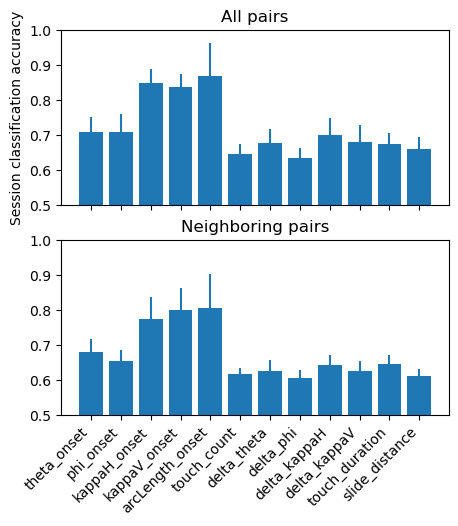

In [63]:
fig, ax = plt.subplots(2,1,figsize=(5,5), sharex=True)
ax[0].bar(range(12), all_acc.mean(axis=0))
ax[0].errorbar(range(12), all_acc.mean(axis=0), yerr=all_acc.std(axis=0), fmt='none')
ax[0].set_title('All pairs')
ax[1].bar(range(12), neighbor_acc.mean(axis=0))
ax[1].errorbar(range(12), neighbor_acc.mean(axis=0), yerr=neighbor_acc.std(axis=0), fmt='none')
ax[1].set_title('Neighboring pairs')
ax[1].set_xticks(range(12))
ax[1].set_xticklabels(whisker_feature_names, rotation=45, ha='right');
ax[0].set_ylabel('Session classification accuracy')
for ai in range(2):
    
    ax[ai].set_ylim(0.5, 1)


# Session classification using during touch features only
- Plus touch count
- Using multiprocessing

## Results analysis

Text(0, 0.5, 'Accuracy')

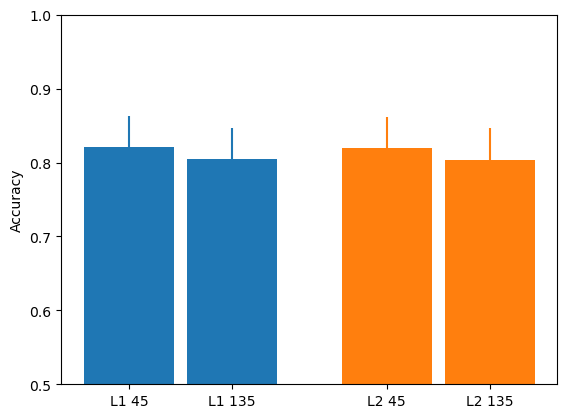

In [80]:
logireg_dir = results_dir / r'during_touch_whisker_feature_discrim\session_discrim'
acc_45_l1 = []
acc_135_l1 = []
acc_45_l2 = []
acc_135_l2 = []
for mouse in mice:
    for volume in range(1,3):
        penalty = 'l1'
        fn = logireg_dir / f'JK{mouse:03}_volume{volume}_session_discrim_logireg_results_{penalty}_during_touch.npy'
        result = np.load(fn, allow_pickle=True).item()
        acc_45_l1.append(result['accuracy_45'][np.triu_indices(result['accuracy_45'].shape[0], k=1)].mean())
        acc_135_l1.append(result['accuracy_135'][np.triu_indices(result['accuracy_135'].shape[0], k=1)].mean())

        penalty = 'l2'
        fn = logireg_dir / f'JK{mouse:03}_volume{volume}_session_discrim_logireg_results_{penalty}_during_touch.npy'
        result = np.load(fn, allow_pickle=True).item()
        acc_45_l2.append(result['accuracy_45'][np.triu_indices(result['accuracy_45'].shape[0], k=1)].mean())
        acc_135_l2.append(result['accuracy_135'][np.triu_indices(result['accuracy_135'].shape[0], k=1)].mean())
fig, ax = plt.subplots()
ax.bar(0.8, np.mean(acc_45_l1), color='C0', width=0.35)
ax.bar(1.2, np.mean(acc_135_l1), color='C0', width=0.35)
ax.bar(1.8, np.mean(acc_45_l2), color='C1', width=0.35)
ax.bar(2.2, np.mean(acc_135_l2), color='C1', width=0.35)
ax.errorbar(0.8, np.mean(acc_45_l1), yerr=np.std(acc_45_l1), fmt='none', color='C0')
ax.errorbar(1.2, np.mean(acc_135_l1), yerr=np.std(acc_135_l1), fmt='none', color='C0')
ax.errorbar(1.8, np.mean(acc_45_l2), yerr=np.std(acc_45_l2), fmt='none', color='C1')
ax.errorbar(2.2, np.mean(acc_135_l2), yerr=np.std(acc_135_l2), fmt='none', color='C1')
ax.set_ylim(0.5, 1)
ax.set_xticks([0.8, 1.2, 1.8, 2.2])
ax.set_xticklabels(['L1 45', 'L1 135', 'L2 45', 'L2 135']);
ax.set_ylabel('Accuracy')

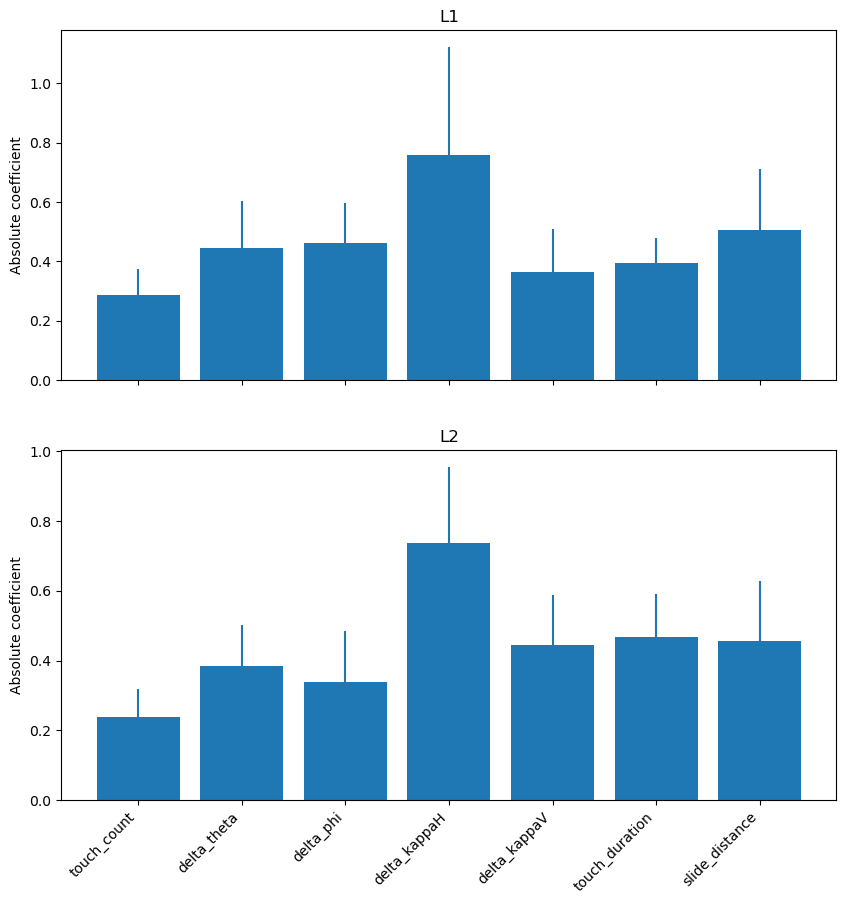

In [70]:
logireg_dir = results_dir / r'during_touch_whisker_feature_discrim\session_discrim'
angles = [45, 135]
coeffs_all = np.zeros((len(mice), 2, 2, 2, 7))
for mouse in mice:
    for vi, volume in enumerate(range(1,3)):
        for pi, penalty in enumerate(['l1', 'l2']):
            fn = logireg_dir / f'JK{mouse:03}_volume{volume}_session_discrim_logireg_results_{penalty}_during_touch.npy'
            result = np.load(fn, allow_pickle=True).item()
            for ai in range(2):
                angle = angles[ai]
                temp_mat = result[f'coeff_{angle}']
                neighboring_abs_coeff_temp = np.stack([np.abs(temp_mat[i,j,1:]) for (i,j) in zip(range(temp_mat.shape[0]-1), range(1, temp_mat.shape[0]))])
                abs_coeff_temp = np.stack([np.stack([np.abs(temp_mat[i,j,1:]) for i in range(temp_mat.shape[0]-1)])
                                          for j in range(1, temp_mat.shape[0])])
                coeffs_all[mice.index(mouse), vi, pi, ai, :] = np.mean(abs_coeff_temp, axis=(0,1))
whisker_feature_names = ['touch_count', 'delta_theta', 'delta_phi',
    'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
grand_mean = np.mean(coeffs_all, axis=(0,1,2))
grand_std = np.std(coeffs_all, axis=(0,1,2))
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)
title_texts = ['L1', 'L2']
for i in range(2):
    ax[i].bar(range(7), grand_mean[i,:])
    ax[i].errorbar(range(7), grand_mean[i,:],
                yerr=grand_std[i,:], fmt='none')
    ax[i].set_title(title_texts[i])
    ax[i].set_ylabel('Absolute coefficient')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(whisker_feature_names, rotation=45, ha='right');


# Feature encoding
- L2 only for now
- Add L1 when it's done

In [2]:
glm_dir = results_dir / 'neuron_glm/ridge/whisker_combined'
mouse = 25
plane = 1
volume = 1 if plane < 5 else 2
sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])
session = sessions[0]
fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
with xr.open_dataset(fn) as glm:
    glm.load()


In [6]:
from scripts import fit_glm_whisker_combined as glm_whisker
glm_split = np.load(glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_split.npy', allow_pickle=True).item()

whisker_feature_names_base = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
        'arc_length_onset', 'touch_count', 'delta_theta', 'delta_phi',
        'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
whisker_feature_dict = {key: [value for value in glm.X.feature.values if key in value] for key in whisker_feature_names_base}
varexp_drop, predicted_drop, W_drop, lambdas_drop = \
    glm_whisker.drop_feature_and_fit(glm.X, glm.traces, 
                                     glm_split['lambda_groups'], glm_split['fit_groups'],
                                     whisker_feature_dict)

### Run this AGAIN in multiprocessing
- Don't have the results somehow

In [7]:
from multiprocessing import cpu_count
print(cpu_count())

40


In [3]:
glm

<xarray.Dataset>
Dimensions:             (index: 4106, cell_id: 120, dropped_feature: 5,
                         feature: 88, fold: 5, lambdas: 120)
Coordinates:
  * index               (index) int32 0 1 2 3 4 5 ... 4101 4102 4103 4104 4105
  * cell_id             (cell_id) int32 0 1 2 4 5 7 ... 140 141 142 143 144 145
  * lambdas             (lambdas) float64 1.963e+03 18.74 ... 7.055e+03
  * feature             (feature) object 'intercept' ... 'first_reward_lick_r...
  * dropped_feature     (dropped_feature) object 'whisker_feature' ... 'reward'
  * fold                (fold) object 'fold_0' 'fold_1' ... 'fold_3' 'fold_4'
Data variables:
    predicted_drop      (index, cell_id, dropped_feature) float64 0.02359 ......
    traces              (index, cell_id) float32 1.097 -0.2208 ... -0.1355
    predicted_final     (index, cell_id) float64 -0.03048 -0.4928 ... -0.02183
    predicted_fold      (index, cell_id) float64 -0.008062 -0.5529 ... -0.02192
    X                   (index, feature) float64 1.0 4.044e-17 ... 0.0 0.0
    varexp_model_fold   (cell_id, fold) float64 0.005587 0.01392 ... -0.0002483
    varexp_drop         (cell_id, dropped_feature) float64 0.01753 ... 0.003408
    lambdas_drop        (cell_id, dropped_feature) float64 2.783e+03 ... 7.05...
    varexp_model_final  (cell_id) float64 0.03603 0.3979 ... 0.02148 0.00341
    W_fold              (feature, cell_id, fold) float64 -0.0257 ... -0.0002127
    W_drop              (feature, cell_id, dropped_feature) float64 -0.01933 ...
    W_final             (feature, cell_id) float64 -0.02783 ... -0.0001814

# Subsampling test
- Using during touch features only (+ touch count)
- Working protocol
    1. Standardize whisker features of same angle between a pair of sessions
    2. Measure pairwise distances between trials
    3. Select at least 30 pairs that are closest to each other
    4. Grow numbers until LDA performance gets higher than 55% correct rate

In [3]:
mouse = 25
volume = 2
sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])
wf_mean_all = None
for session in sessions:
    wf_mean_temp = get_whisker_feature_df(mouse, volume, session, results_dir)
    if wf_mean_all is None:
        wf_mean_all = wf_mean_temp
    else:
        wf_mean_all = pd.concat([wf_mean_all, wf_mean_temp])


In [43]:
def get_best_matching_pairs_inds(between_session_dist, coords, min_num_pairs=15,
                                 threshold=0.55, scaling_factor=50):
    num_trials = between_session_dist.shape
    row_ind, col_ind = linear_sum_assignment(between_session_dist)
    pair_distances = between_session_dist[row_ind, col_ind]
    sort_ind = np.argsort(pair_distances)
    
    lower_than_threshold_num_pairs = [0]
    higher_than_threshold_num_pairs = [min(num_trials)+1]

    num_pairs_tested = []
    acc_tested = []
    num_pairs = min(30, min(num_trials))
    while (num_pairs not in higher_than_threshold_num_pairs) and \
        (num_pairs not in lower_than_threshold_num_pairs) and \
        (num_pairs >= min_num_pairs) and \
        (num_pairs <= min(num_trials)):
        temp_row_ind = row_ind[sort_ind[:num_pairs]]
        temp_col_ind = col_ind[sort_ind[:num_pairs]]
        temp_x = np.vstack([coords[temp_row_ind, :], coords[temp_col_ind + num_trials[0], :]])
        temp_y = np.concatenate([np.zeros(num_pairs), np.ones(num_pairs)])
        temp_acc, _ = logireg_angle.get_logireg_results(temp_x, temp_y)
        # print(num_pairs, temp_acc)
        num_pairs_tested.append(num_pairs)
        acc_tested.append(temp_acc)
        if temp_acc < threshold:
            lower_than_threshold_num_pairs.append(num_pairs)
            num_pairs = num_pairs + int((threshold - temp_acc) * scaling_factor)
            if num_pairs >= np.min(higher_than_threshold_num_pairs):
                num_pairs = np.min(higher_than_threshold_num_pairs) - 1
            elif num_pairs <= np.max(lower_than_threshold_num_pairs):
                num_pairs = np.max(lower_than_threshold_num_pairs) + 1
        else:
            higher_than_threshold_num_pairs.append(num_pairs)
            num_pairs = num_pairs - int((temp_acc - threshold) * scaling_factor)
            if num_pairs <= np.max(lower_than_threshold_num_pairs):
                num_pairs = np.max(lower_than_threshold_num_pairs) + 1
            elif num_pairs >= np.min(higher_than_threshold_num_pairs):
                num_pairs = np.min(higher_than_threshold_num_pairs) - 1
    if num_pairs < min_num_pairs:
        return None, None, None, None
    assert np.min(higher_than_threshold_num_pairs) == np.max(lower_than_threshold_num_pairs) + 1
    max_num_trials = np.max(lower_than_threshold_num_pairs)
    max_test_ind = np.where(np.array(num_pairs_tested) == max_num_trials)[0][0]
    accuracy = acc_tested[max_test_ind]
    choose_row_ind = row_ind[sort_ind[:max_num_trials]]
    choose_col_ind = col_ind[sort_ind[:max_num_trials]]

    return choose_row_ind, choose_col_ind, max_num_trials, accuracy

In [68]:
def get_matching_trial_nums_between_sessions(comp_sessions, wf_mean_all):
    during_feature_names = ['touch_count', 'delta_theta', 'delta_phi',
        'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
    angles = [45, 135]

    comp_wf = wf_mean_all.query('session in @comp_sessions')
    trialNum_session_0 = []
    trialNum_session_1 = []
    for angle in angles:
        temp_df = comp_wf.query('pole_angle == @angle')
        std_df = temp_df.copy()
        for feature in during_feature_names:
            std_df[feature] = (temp_df[feature] - temp_df[feature].mean()) / temp_df[feature].std()
        coords = std_df[during_feature_names].values
        pairwise_dist = squareform(pdist(coords))
        num_trials = std_df.groupby('session').size().values
        between_session_dist = pairwise_dist[:num_trials[0], num_trials[0]:]
        # mean_within_dist = (pairwise_dist[:num_trials[0], :num_trials[0]][np.triu_indices(num_trials[0], k=1)].mean() +
        #                     pairwise_dist[num_trials[0]:, num_trials[0]:][np.triu_indices(num_trials[1], k=1)].mean()) / 2
        choose_row_ind, choose_col_ind, max_num_trials, accuracy = get_best_matching_pairs_inds(between_session_dist, coords)
        if choose_row_ind is None:
            return None

        trialNum_session_0_all = std_df.query('session == @comp_sessions[0]').trialNum.values
        assert (np.sort(trialNum_session_0_all) == trialNum_session_0_all).all()
        trialNum_session_0.append([trialNum_session_0_all[i] for i in choose_row_ind])
        trialNum_session_1_all = std_df.query('session == @comp_sessions[1]').trialNum.values
        assert (np.sort(trialNum_session_1_all) == trialNum_session_1_all).all()
        trialNum_session_1.append([trialNum_session_1_all[i] for i in choose_col_ind])

    assert [len(t) for t in trialNum_session_0] == [len(t) for t in trialNum_session_1]
    assert (len(np.intersect1d(trialNum_session_0[0], trialNum_session_0[1]))) == 0

    balanced_num_trials = min([len(t) for t in trialNum_session_0])
    trialNum_session_0 = [t[:balanced_num_trials] for t in trialNum_session_0]
    trialNum_session_1 = [t[:balanced_num_trials] for t in trialNum_session_1]
    trialNum_pair_dict = {f'{comp_sessions[0]}': np.concatenate(trialNum_session_0),
                          f'{comp_sessions[1]}': np.concatenate(trialNum_session_1)}
    return trialNum_pair_dict


In [ ]:
mouse = 25
volume = 2
sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])
wf_mean_all = None
for session in sessions:
    wf_mean_temp = get_whisker_feature_df(mouse, volume, session, results_dir)
    if wf_mean_all is None:
        wf_mean_all = wf_mean_temp
    else:
        wf_mean_all = pd.concat([wf_mean_all, wf_mean_temp])
matching_trialNum_dict = {}
print(len(sessions))
for i in range(len(sessions)-1):
    for j in range(i+1, len(sessions)):
        print(f'Processing {i} and {j}')
        comp_sessions = [sessions[i], sessions[j]]
        trialNum_pair_dict = get_matching_trial_nums_between_sessions(comp_sessions, wf_mean_all)
        matching_trialNum_dict[f'{comp_sessions[0]}_{comp_sessions[1]}'] = trialNum_pair_dict



## Running in parallel
- scripts/trial_subsampling_par.py

## Checking the result

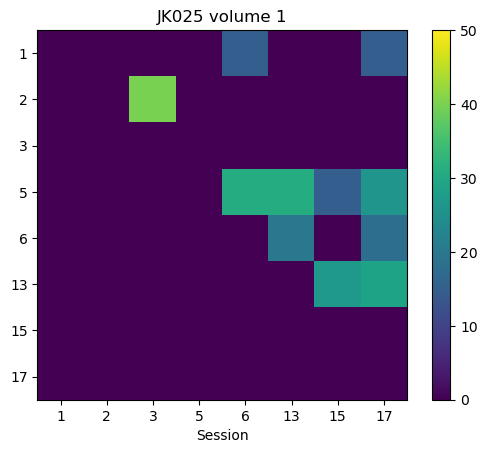

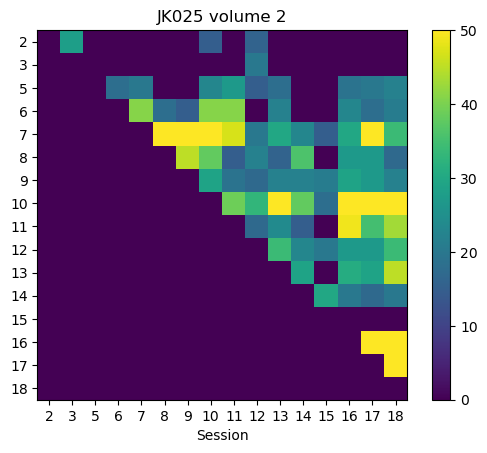

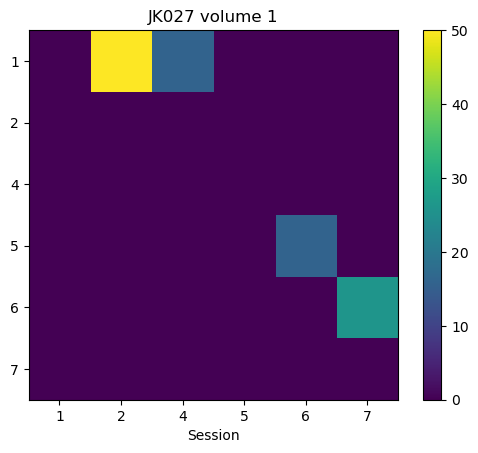

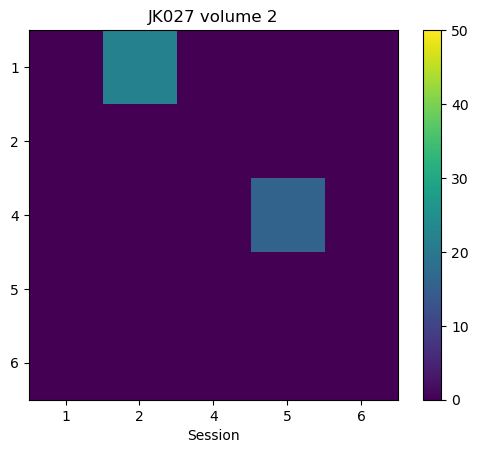

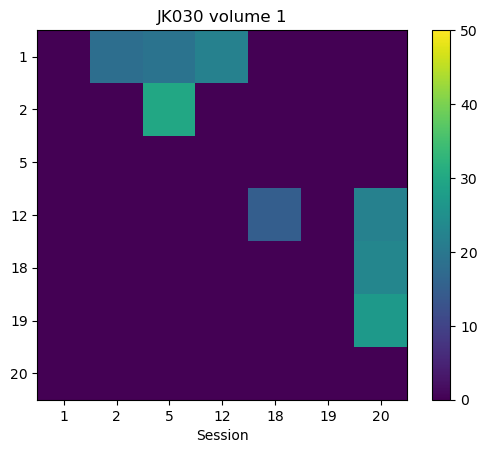

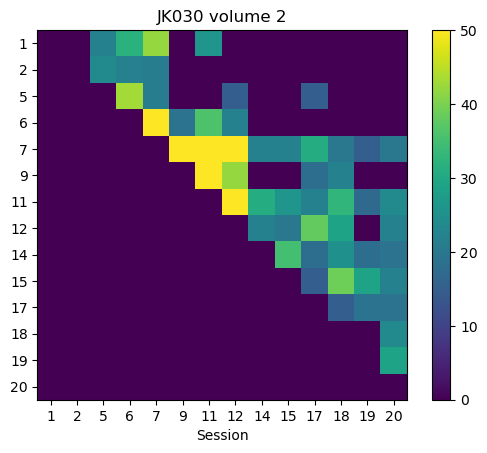

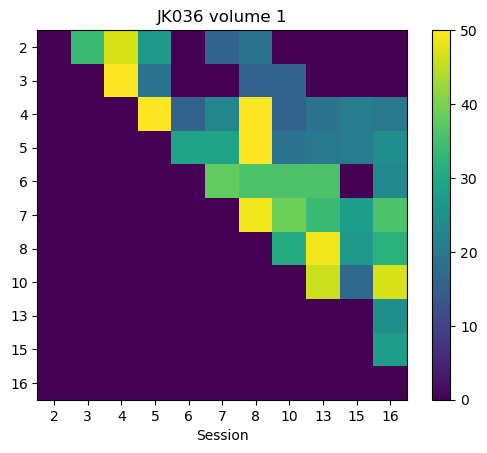

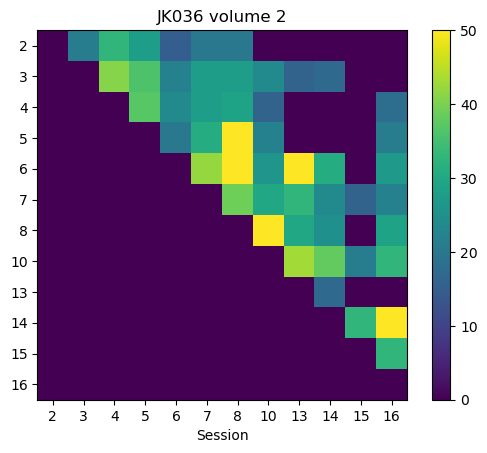

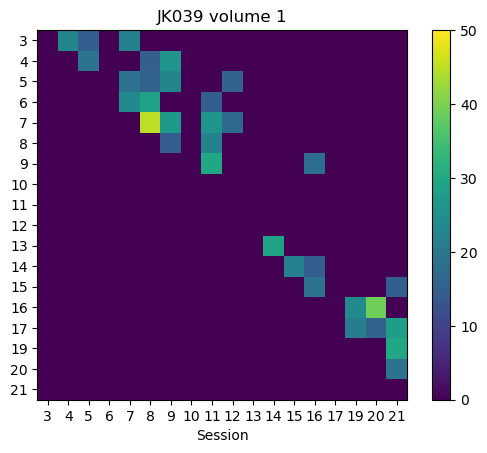

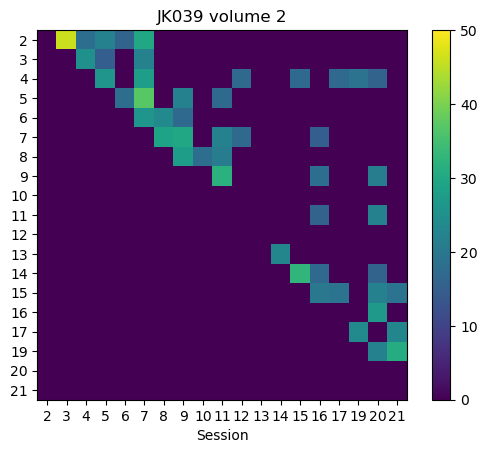

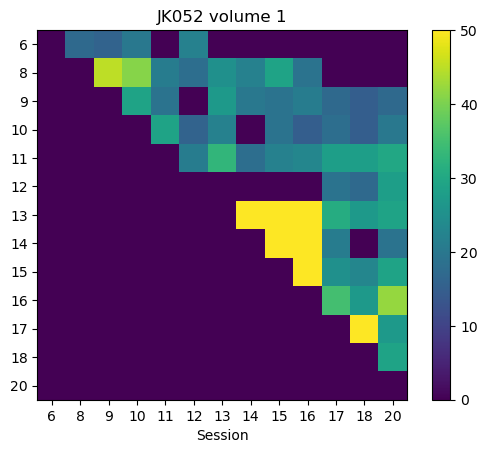

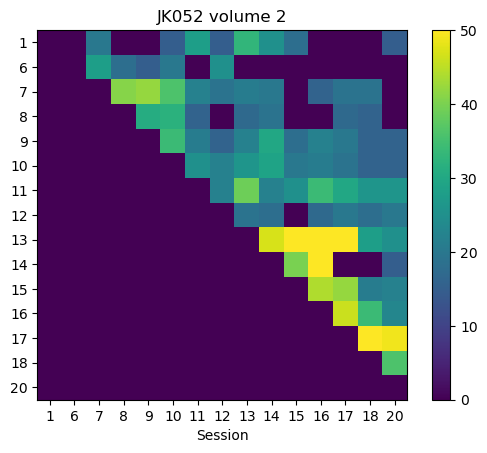

In [46]:
for mouse in mice:
    for volume in range(1,3):
        sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])

        save_dir = results_dir / 'trial_subsampling'
        load_fn = save_dir / f'JK{mouse:03}_volume{volume}_matching_trialNum_dict.pkl'
        if load_fn.exists():
            with open(load_fn, 'rb') as f:
                temp_dict = pickle.load(f)

            num_trial_mat = np.zeros((len(sessions), len(sessions)))
            keys = list(temp_dict.keys())
            for key in keys:
                if temp_dict[key] is None:
                    num_trials = 0
                else:
                    session_0 = key.split('_')[0]
                    num_trials = len(temp_dict[key][session_0])/2
                session_0 = int(key.split('_')[0])
                session_1 = int(key.split('_')[1])
                num_trial_mat[sessions == session_0, sessions == session_1] = num_trials

            fig, ax = plt.subplots()
            im = ax.imshow(num_trial_mat, vmin=0, vmax=50)
            plt.colorbar(im, ax=ax)
            ax.set_title(f'JK{mouse:03} volume {volume}')
            ax.set_xticks(range(len(sessions)))
            ax.set_xticklabels(sessions)
            ax.set_yticks(range(len(sessions)))
            ax.set_yticklabels(sessions)
            ax.set_xlabel('Session')